In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [58]:
# Set up paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Dataset", "Rwandandishies")
NUTRITION_DATA_PATH = os.path.join(BASE_DIR, "data", "nutrition", "rwandan_food_data.csv")
MODELS_DIR = os.path.join(BASE_DIR, "models")

In [59]:
# Load the CSV data
df = pd.read_csv(NUTRITION_DATA_PATH)

In [60]:
# 1. Dataset Overview
print(f"Total number of dishes: {len(df)}")
print(f"Columns in the dataset: {', '.join(df.columns)}")

Total number of dishes: 24
Columns in the dataset: Name, Serving Size, Calories, Protein (g), Carbs (g), Sugars (g), Fiber (g), Total Fat (g), Saturated Fat (g), Sodium (mg), Vitamin A (%DV), Vitamin C (%DV), Calcium (%DV), Iron (%DV), Ingredients, Allergens, Dietary Info


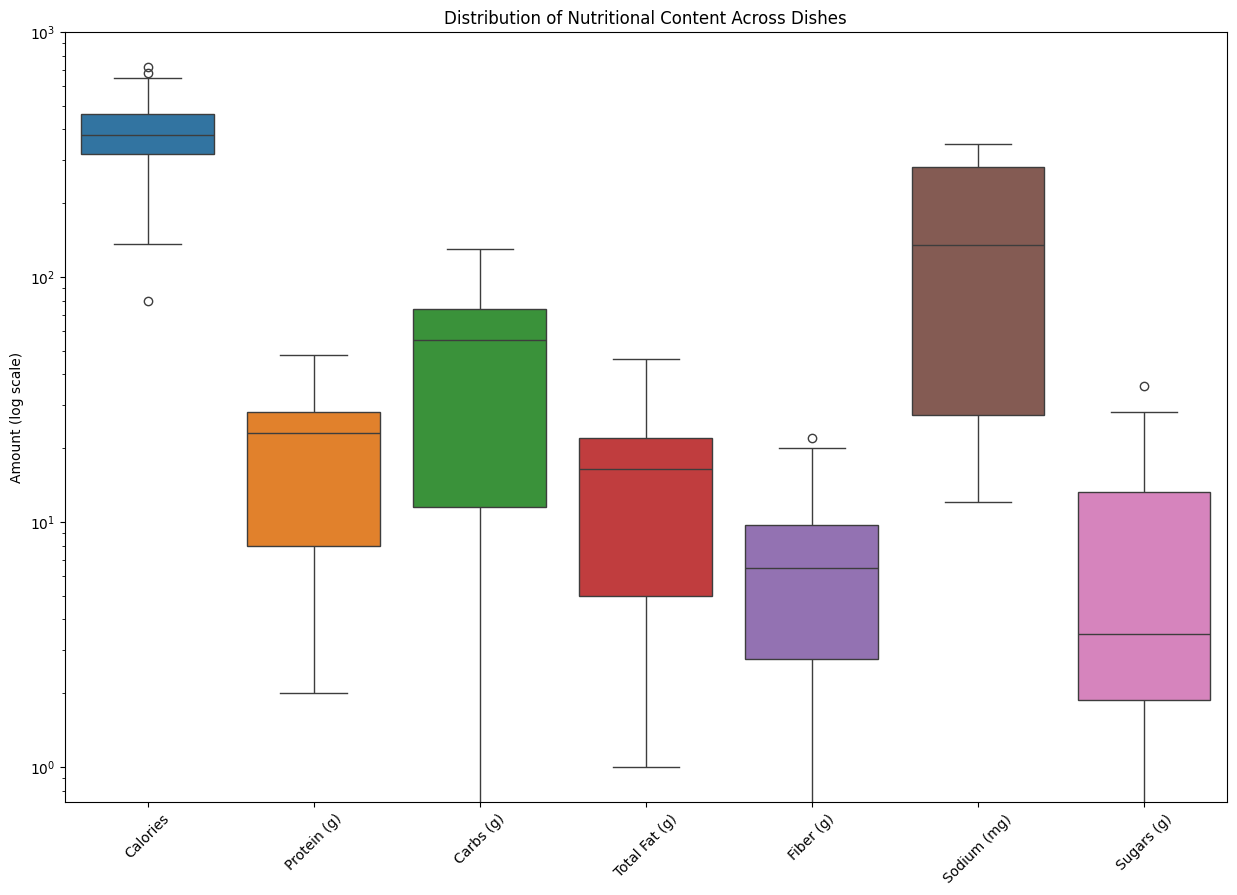

In [61]:
# 2. Nutritional Content Distribution
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[['Calories', 'Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)', 'Sodium (mg)', 'Sugars (g)']])
plt.title('Distribution of Nutritional Content Across Dishes')
plt.yscale('log')
plt.ylabel('Amount (log scale)')
plt.xticks(rotation=45)
plt.show()

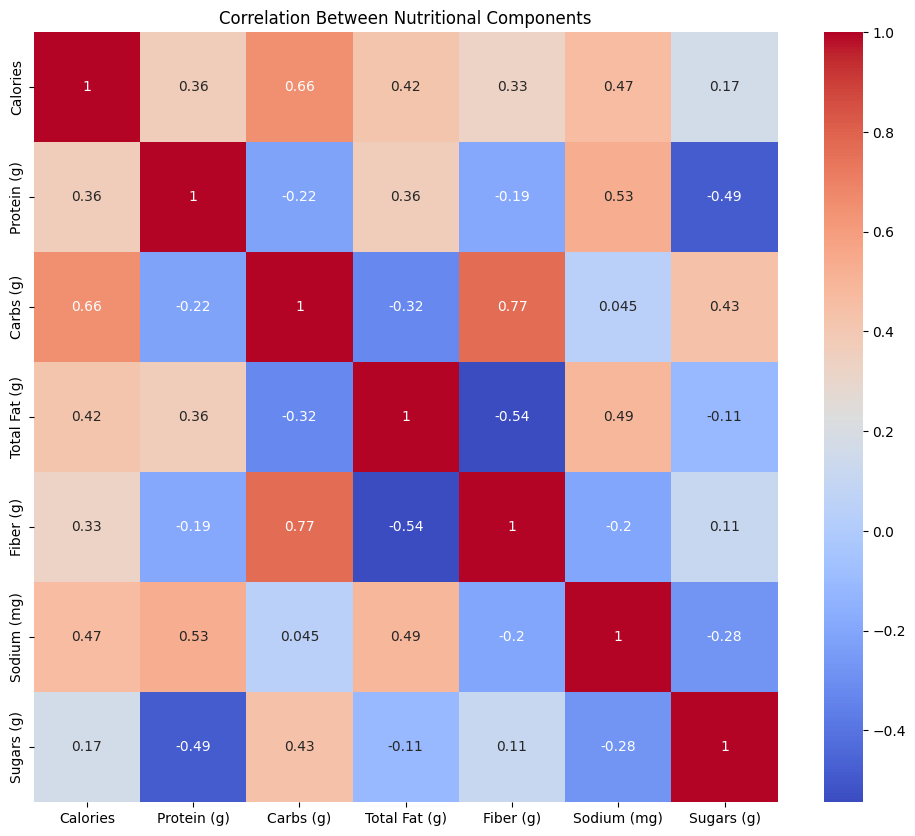

In [62]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[['Calories', 'Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)', 'Sodium (mg)', 'Sugars (g)']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Nutritional Components')
plt.show()

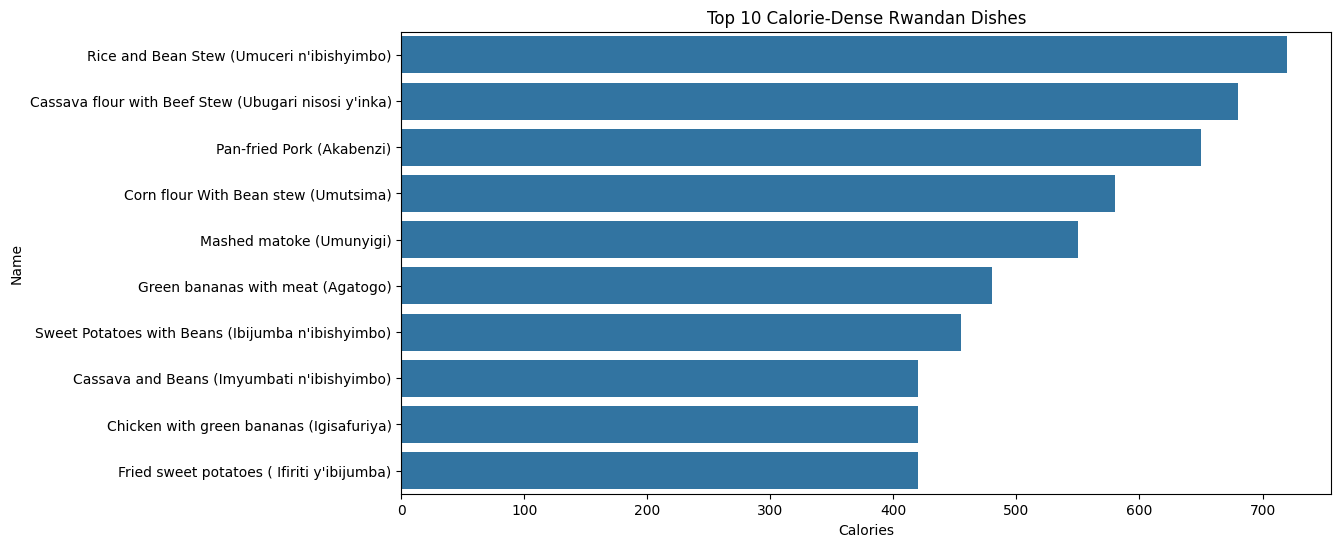

In [63]:
# 4. Top 10 Calorie-Dense Dishes
plt.figure(figsize=(12, 6))
top_10_calories = df.nlargest(10, 'Calories')
sns.barplot(x='Calories', y='Name', data=top_10_calories)
plt.title('Top 10 Calorie-Dense Rwandan Dishes')
plt.xlabel('Calories')
plt.show()

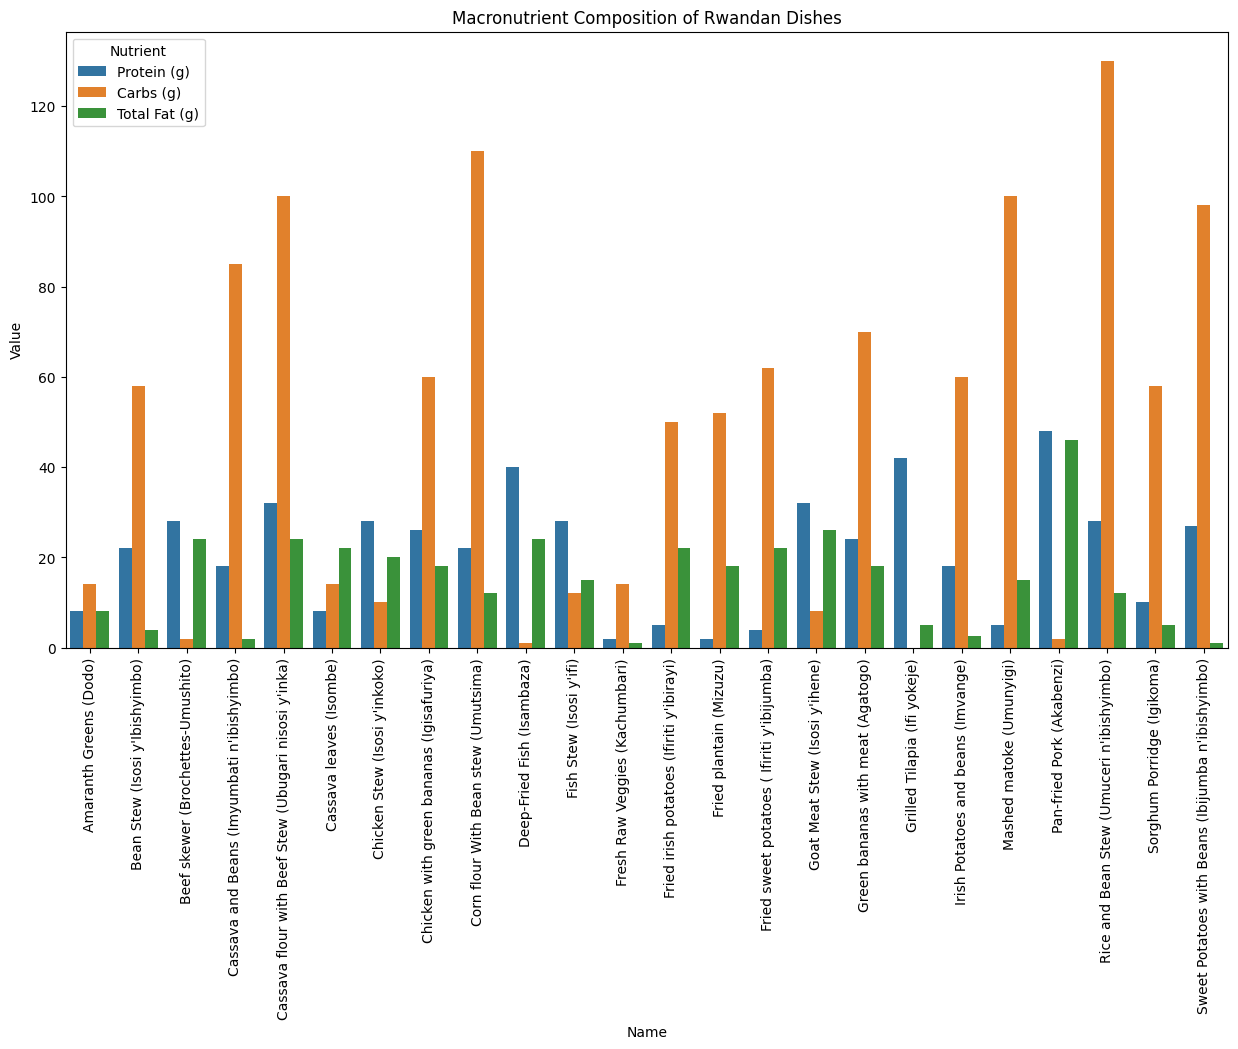

In [64]:
# 5. Macronutrient Composition
plt.figure(figsize=(15, 8))
macronutrients = df[['Name', 'Protein (g)', 'Carbs (g)', 'Total Fat (g)']]
macronutrients_stacked = macronutrients.set_index('Name').stack().reset_index()
macronutrients_stacked.columns = ['Name', 'Nutrient', 'Value']
sns.barplot(x='Name', y='Value', hue='Nutrient', data=macronutrients_stacked)
plt.title('Macronutrient Composition of Rwandan Dishes')
plt.xticks(rotation=90)
plt.legend(title='Nutrient')
plt.show()

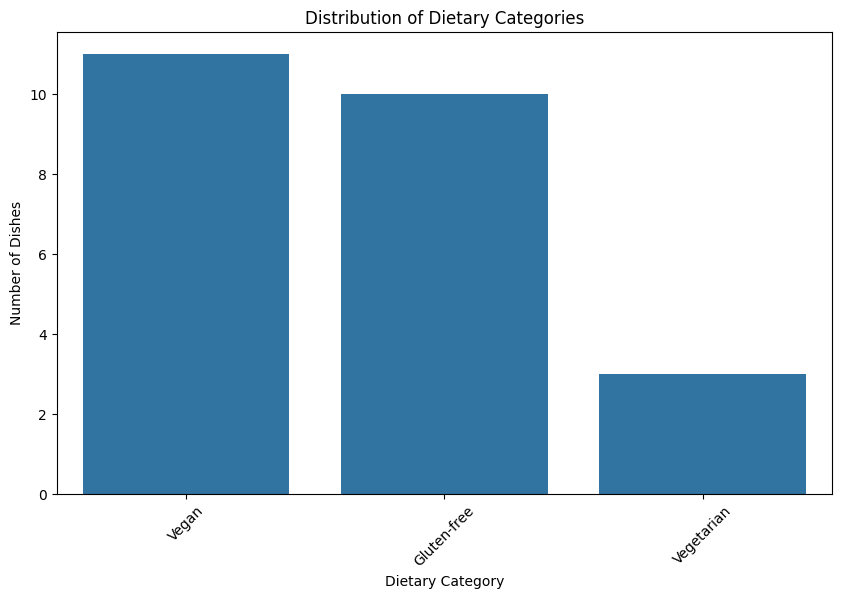

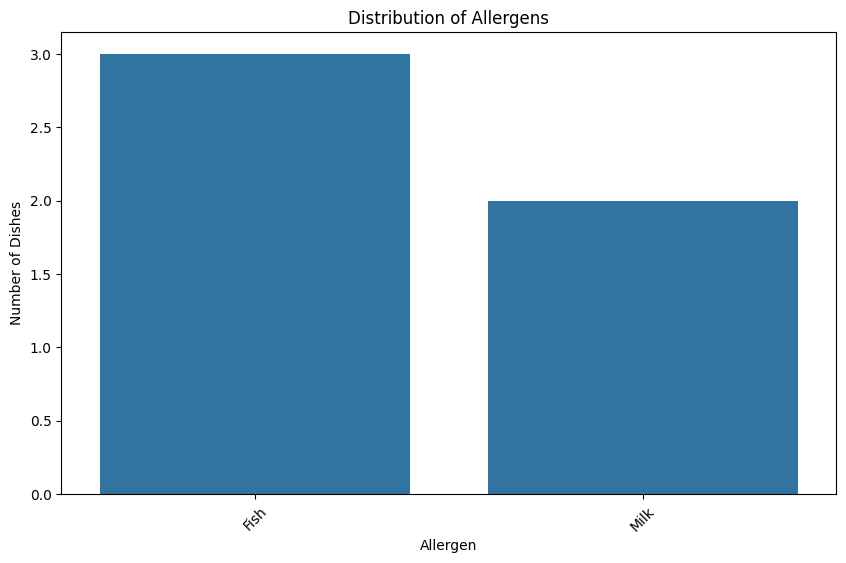

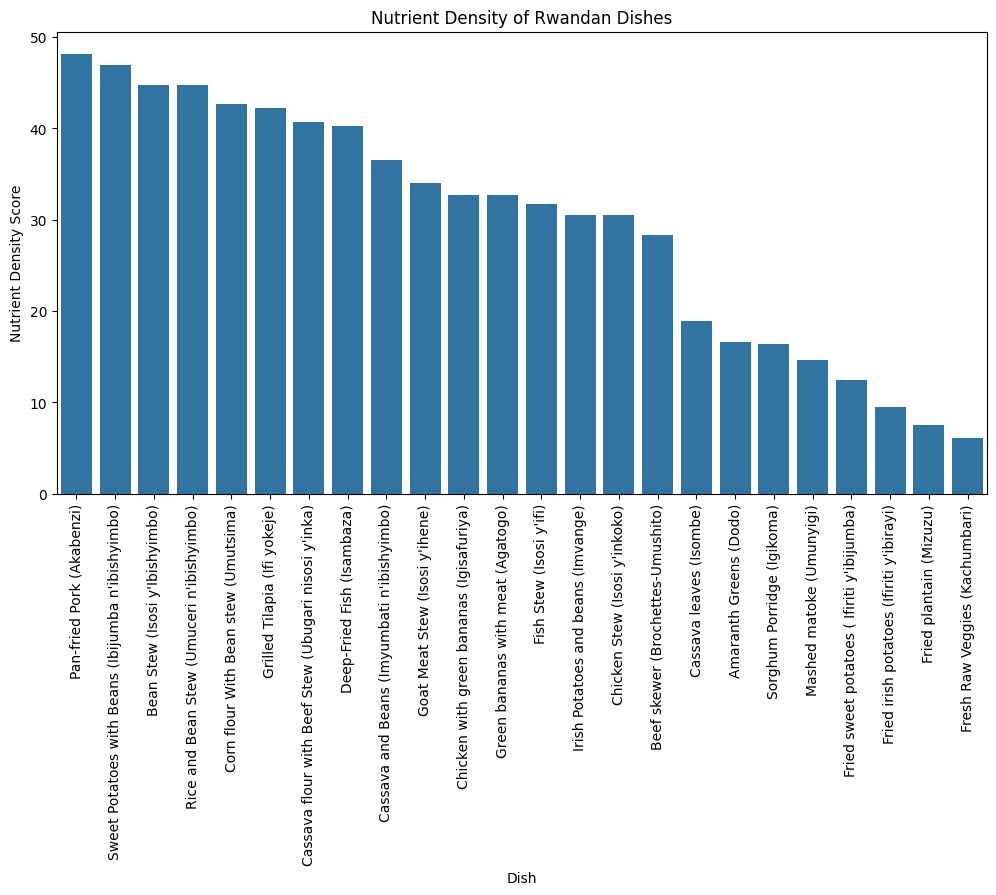

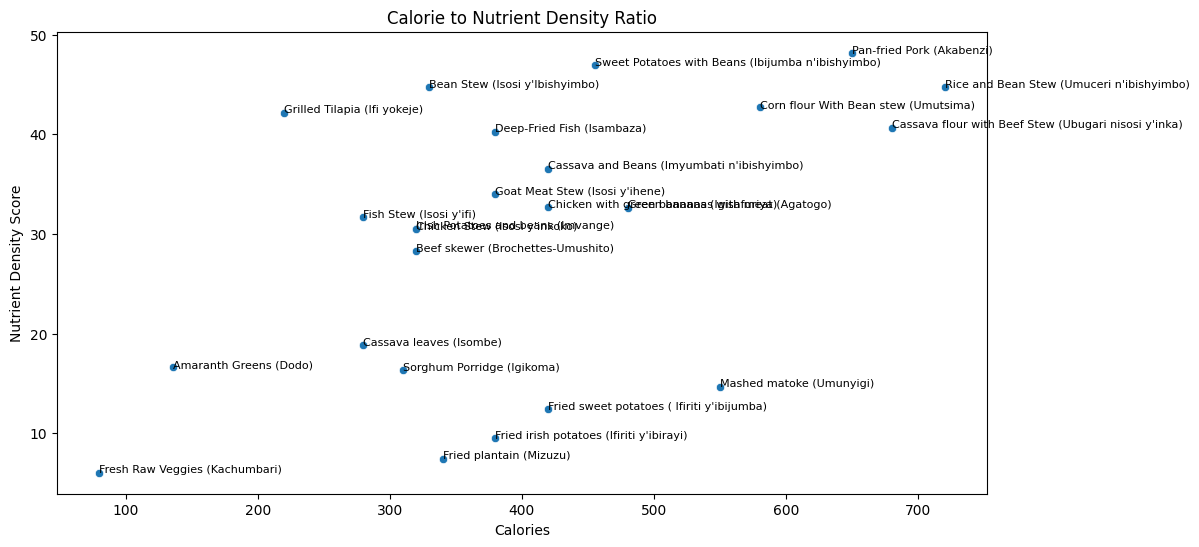

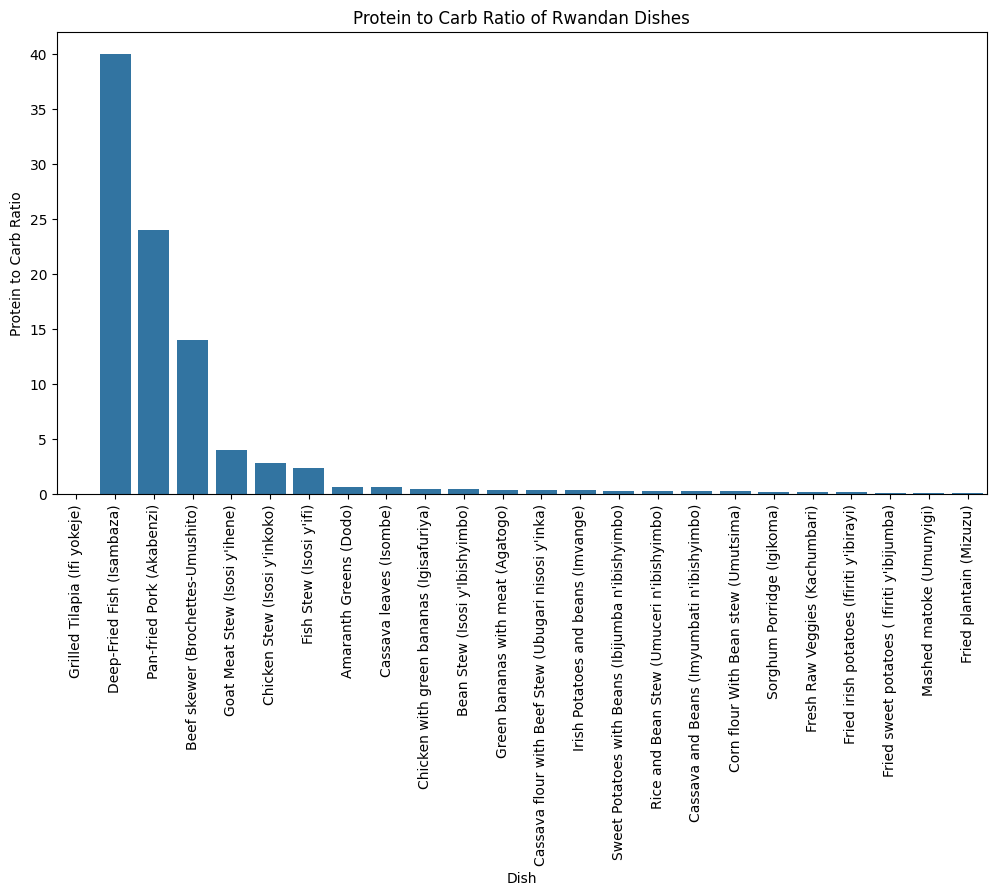

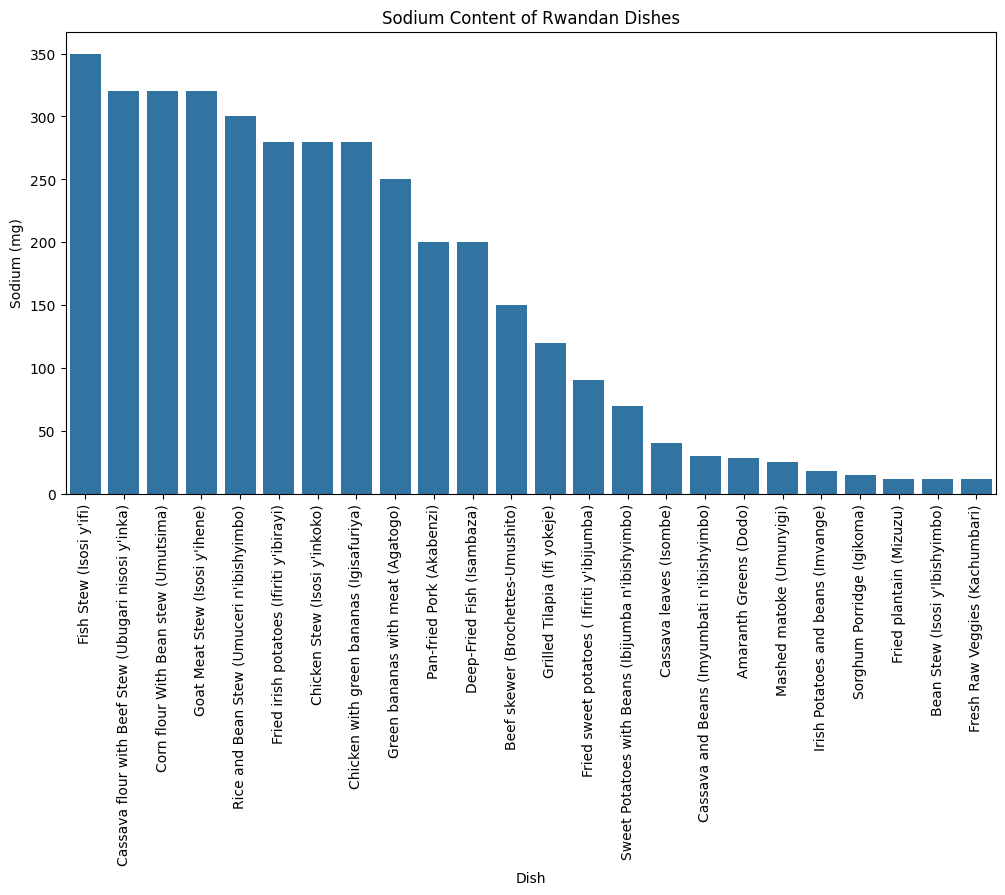

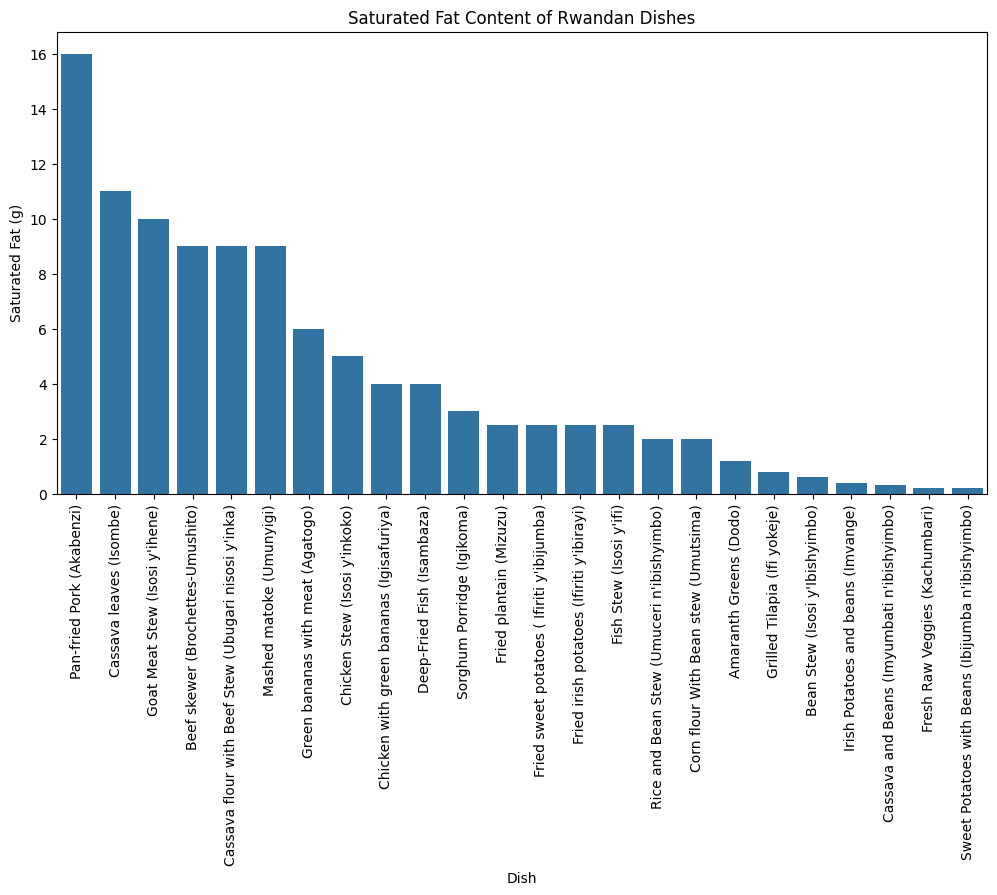


Analysis complete


In [65]:
# Additional Analysis

# 8. Dietary Distribution
plt.figure(figsize=(10, 6))
diet_counts = df['Dietary Info'].value_counts()
sns.barplot(x=diet_counts.index, y=diet_counts.values)
plt.title('Distribution of Dietary Categories')
plt.xlabel('Dietary Category')
plt.ylabel('Number of Dishes')
plt.xticks(rotation=45)
plt.show()

# 9. Allergen Analysis
plt.figure(figsize=(10, 6))
allergen_counts = df['Allergens'].value_counts()
sns.barplot(x=allergen_counts.index, y=allergen_counts.values)
plt.title('Distribution of Allergens')
plt.xlabel('Allergen')
plt.ylabel('Number of Dishes')
plt.xticks(rotation=45)
plt.show()

# 10. Nutrient Density Analysis
df['Nutrient Density'] = df['Protein (g)'] + df['Fiber (g)'] + df['Vitamin A (%DV)']/100 + df['Vitamin C (%DV)']/100 + df['Calcium (%DV)']/100 + df['Iron (%DV)']/100
plt.figure(figsize=(12, 6))
sns.barplot(x='Name', y='Nutrient Density', data=df.sort_values('Nutrient Density', ascending=False))
plt.title('Nutrient Density of Rwandan Dishes')
plt.xlabel('Dish')
plt.ylabel('Nutrient Density Score')
plt.xticks(rotation=90)
plt.show()

# 11. Calorie to Nutrient Ratio
df['Calorie to Nutrient Ratio'] = df['Calories'] / df['Nutrient Density']
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Calories', y='Nutrient Density', data=df)
plt.title('Calorie to Nutrient Density Ratio')
plt.xlabel('Calories')
plt.ylabel('Nutrient Density Score')
for i, txt in enumerate(df['Name']):
    plt.annotate(txt, (df['Calories'].iloc[i], df['Nutrient Density'].iloc[i]), fontsize=8)
plt.show()

# 12. Protein to Carb Ratio
df['Protein to Carb Ratio'] = df['Protein (g)'] / df['Carbs (g)']
plt.figure(figsize=(12, 6))
sns.barplot(x='Name', y='Protein to Carb Ratio', data=df.sort_values('Protein to Carb Ratio', ascending=False))
plt.title('Protein to Carb Ratio of Rwandan Dishes')
plt.xlabel('Dish')
plt.ylabel('Protein to Carb Ratio')
plt.xticks(rotation=90)
plt.show()

# 13. Sodium Content Analysis
plt.figure(figsize=(12, 6))
sns.barplot(x='Name', y='Sodium (mg)', data=df.sort_values('Sodium (mg)', ascending=False))
plt.title('Sodium Content of Rwandan Dishes')
plt.xlabel('Dish')
plt.ylabel('Sodium (mg)')
plt.xticks(rotation=90)
plt.show()

# 14. Saturated Fat Analysis
plt.figure(figsize=(12, 6))
sns.barplot(x='Name', y='Saturated Fat (g)', data=df.sort_values('Saturated Fat (g)', ascending=False))
plt.title('Saturated Fat Content of Rwandan Dishes')
plt.xlabel('Dish')
plt.ylabel('Saturated Fat (g)')
plt.xticks(rotation=90)
plt.show()

print("\nAnalysis complete")

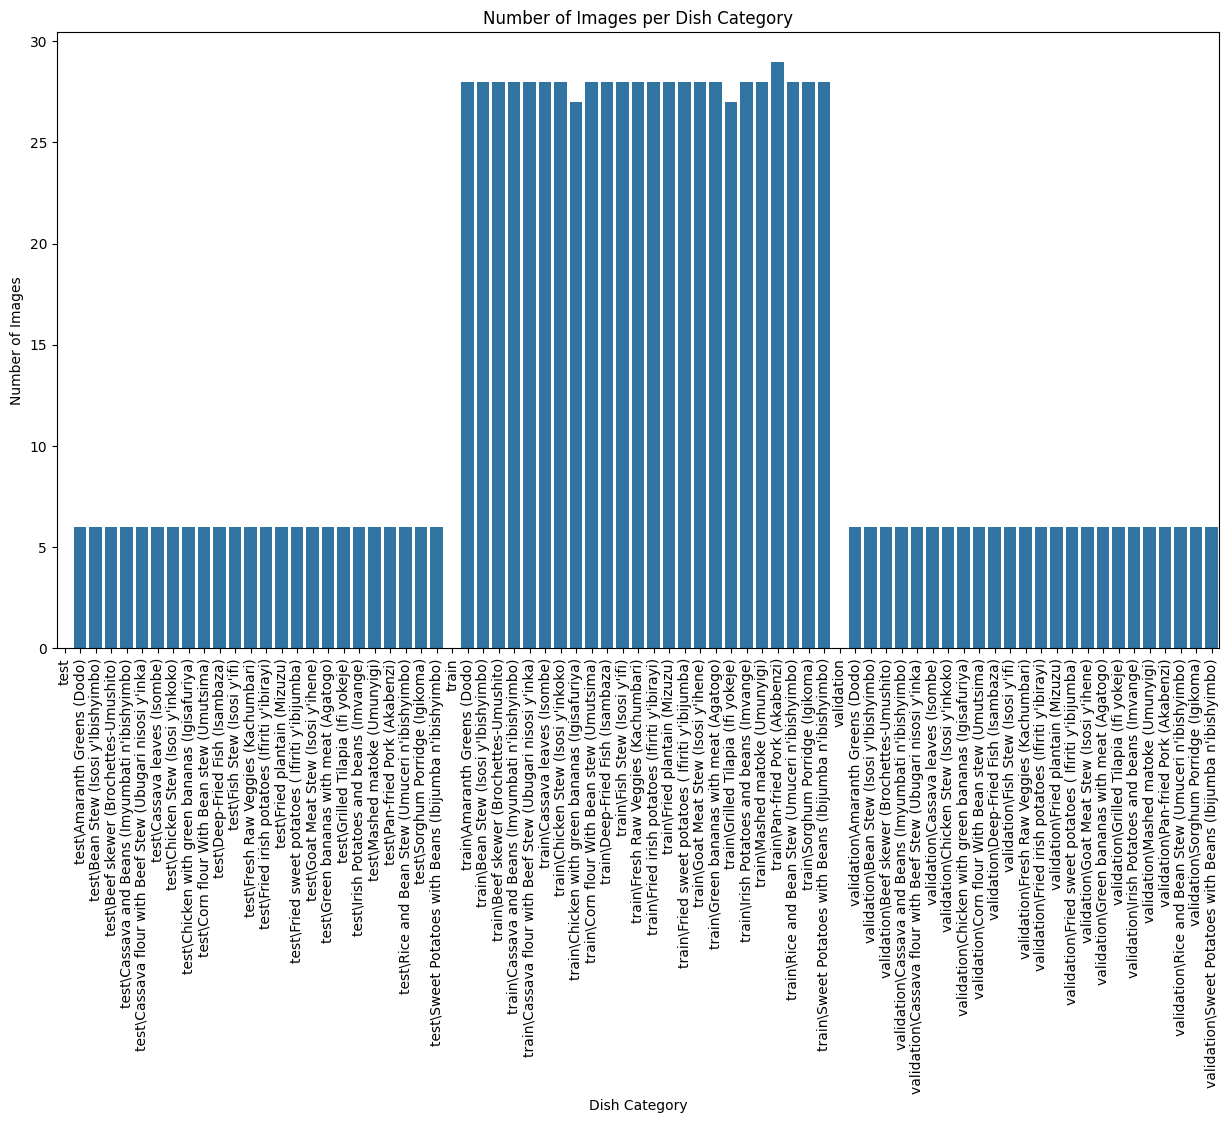

In [66]:
# 6. Image Dataset Analysis
def count_images_in_subfolders(directory):
    image_counts = {}
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.relpath(root, directory)
        if folder_name != '.':
            image_count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
            image_counts[folder_name] = image_count
    return image_counts

image_counts = count_images_in_subfolders(DATA_DIR)

plt.figure(figsize=(15, 8))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Number of Images per Dish Category')
plt.xlabel('Dish Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()


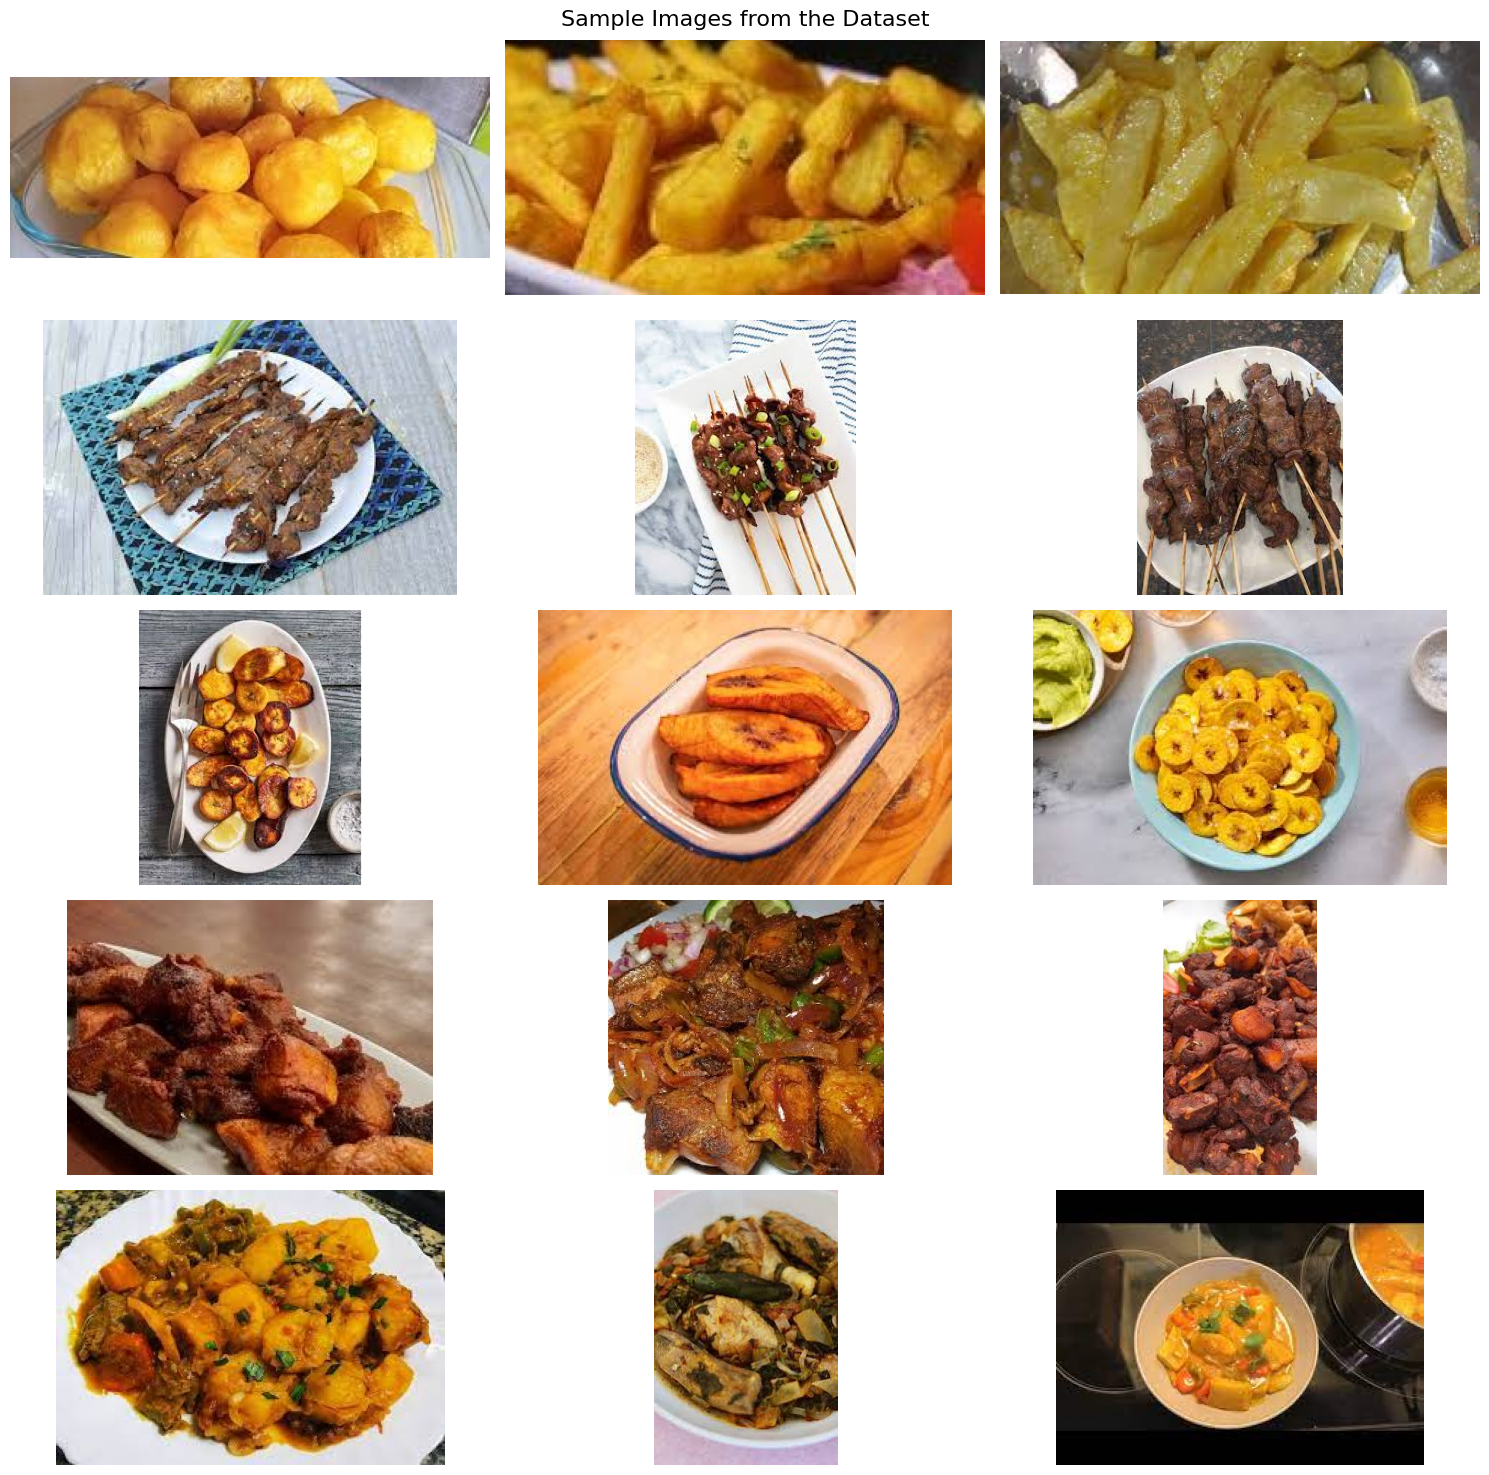

In [67]:
# 7. Sample Images Display
def display_sample_images(data_dir, num_dishes=5, images_per_dish=3):
    subfolders = ['train', 'validation', 'test']
    all_dish_folders = []
    for subfolder in subfolders:
        subfolder_path = os.path.join(data_dir, subfolder)
        dish_folders = [os.path.join(subfolder, f) for f in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, f))]
        all_dish_folders.extend(dish_folders)
    
    num_dishes = min(num_dishes, len(all_dish_folders))
    sample_dishes = np.random.choice(all_dish_folders, num_dishes, replace=False)
    
    fig, axes = plt.subplots(num_dishes, images_per_dish, figsize=(15, 3*num_dishes))
    fig.suptitle('Sample Images from the Dataset', fontsize=16)
    
    if num_dishes == 1:
        axes = axes.reshape(1, -1)
    
    for i, dish_path in enumerate(sample_dishes):
        full_dish_path = os.path.join(data_dir, dish_path)
        images = [f for f in os.listdir(full_dish_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
        images_to_display = min(images_per_dish, len(images))
        sample_images = np.random.choice(images, images_to_display, replace=False)
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(full_dish_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(f"{os.path.basename(dish_path)}\n({os.path.dirname(dish_path)})", rotation=0, labelpad=50, va='center')
        
        for j in range(images_to_display, images_per_dish):
            axes[i, j].axis('off')
            axes[i, j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

display_sample_images(DATA_DIR)

In [68]:
# Data Preprocessing and Augmentation
def preprocess_data(data_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Compute class weights
    y_train = train_generator.classes
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return train_generator, validation_generator, test_generator, class_weight_dict

In [69]:
# Improved Model Creation
def create_mobilenetv2_model(num_classes, input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

def create_resnet50_model(num_classes, input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

def create_inceptionv3_model(num_classes, input_shape=(299, 299, 3)):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

def create_efficientnetb0_model(num_classes, input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

def create_custom_cnn_model(num_classes, input_shape=(224, 224, 3)):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [70]:
# Training function with learning rate scheduling and early stopping
def train_model(model, train_generator, validation_generator, class_weight_dict, epochs=50):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return history

def evaluate_model(model, test_generator):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def compare_models(models, test_generators):
    results = {}
    for name, model in models.items():
        print(f"Evaluating {name}...")
        results[name] = evaluate_model(model, test_generators[name])
    
    # Print results
    for name, metrics in results.items():
        print(f"\n{name} Results:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    # Determine the best model
    best_model = max(results, key=lambda x: results[x]['f1'])
    print(f"\nBest model based on F1 score: {best_model}")
    
    return best_model, results

In [71]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def calculate_bmi(height, weight):
    return weight / (height / 100) ** 2

def get_dietary_recommendations(bmi, health_goal):
    if bmi < 18.5:
        if health_goal == 'gain_weight':
            return "high_calorie"
        else:
            return "balanced"
    elif 18.5 <= bmi < 25:
        return "balanced"
    elif 25 <= bmi < 30:
        if health_goal == 'lose_weight':
            return "low_calorie"
        else:
            return "balanced"
    else:  # BMI >= 30
        return "low_calorie"

def recommend_dishes(user_preferences, height, weight, health_goal, df, num_recommendations=5):
    bmi = calculate_bmi(height, weight)
    dietary_recommendation = get_dietary_recommendations(bmi, health_goal)
    
    # Filter dishes based on dietary recommendation
    if dietary_recommendation == "low_calorie":
        df = df[df['Calories'] < df['Calories'].median()]
    elif dietary_recommendation == "high_calorie":
        df = df[df['Calories'] > df['Calories'].median()]
    
    # Calculate similarity based on user preferences
    df['similarity'] = df[['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].apply(
        lambda row: cosine_similarity(
            [row], 
            [user_preferences[['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']]]
        )[0][0],
        axis=1
    )
    
    # Sort by similarity and return top recommendations
    recommendations = df.sort_values('similarity', ascending=False).head(num_recommendations)
    
    return recommendations



Preprocessing data for MobileNetV2 with image size (224, 224)...
Found 671 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Preprocessing data for ResNet50 with image size (224, 224)...
Found 671 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Preprocessing data for InceptionV3 with image size (299, 299)...
Found 671 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Preprocessing data for EfficientNetB0 with image size (224, 224)...
Found 671 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Preprocessing data for CustomCNN with image size (224, 224)...
Found 671 images belonging to 24 classes.
Found 144 images belonging to 24 classes.
Found 144 images belonging to 24 classes.

Data preprocessing completed.
Number of traini

C:\Users\User\AppData\Local\Temp\ipykernel_37612\1920403921.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)



Training MobileNetV2...
Epoch 1/50


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.0689 - loss: 3.4857 - val_accuracy: 0.3047 - val_loss: 2.5790 - learning_rate: 0.0010
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1875 - loss: 2.8604

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.1875 - loss: 2.8604 - val_accuracy: 0.6250 - val_loss: 2.3778 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2688 - loss: 2.6059 - val_accuracy: 0.3906 - val_loss: 1.9756 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3125 - loss: 2.2838 - val_accuracy: 0.6875 - val_loss: 1.6458 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4107 - loss: 2.0609 - val_accuracy: 0.5234 - val_loss: 1.5295 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3750 - loss: 1.8992 - val_accuracy: 0.6250 - val_loss: 1.3598 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5100 - loss: 1.6795 - val_accuracy: 0.5391 - val_loss: 1.3491 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5625 - loss: 1.4878 - val_accuracy: 0.6875

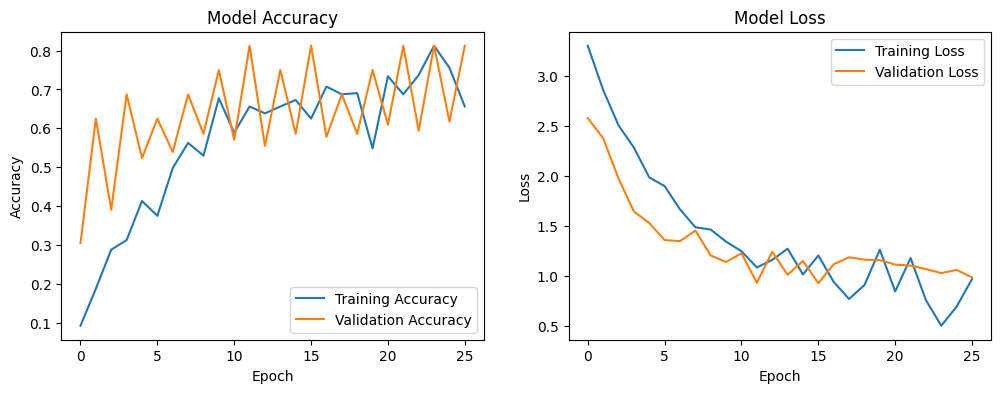


Evaluating MobileNetV2...
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
MobileNetV2 Evaluation Results:
accuracy: 0.6597
precision: 0.7061
recall: 0.6597
f1: 0.6437

Training ResNet50...
Epoch 1/50


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.0450 - loss: 3.5311 - val_accuracy: 0.0469 - val_loss: 3.1786 - learning_rate: 0.0010
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.0000e+00 - loss: 3.2359

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.0000e+00 - loss: 3.2359 - val_accuracy: 0.0000e+00 - val_loss: 3.2250 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.0499 - loss: 3.2593 - val_accuracy: 0.0391 - val_loss: 3.1756 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.0625 - loss: 3.2037 - val_accuracy: 0.3750 - val_loss: 3.1190 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.0489 - loss: 3.1904 - val_accuracy: 0.0547 - val_loss: 3.1569 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.0645 - loss: 3.2436 - val_accuracy: 0.0625 - val_loss: 3.1759 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.0447 - loss: 3.1802 - val_accuracy: 0.0859 - val_loss: 3.1626 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.0000e+00 - loss: 3.2437 - val_

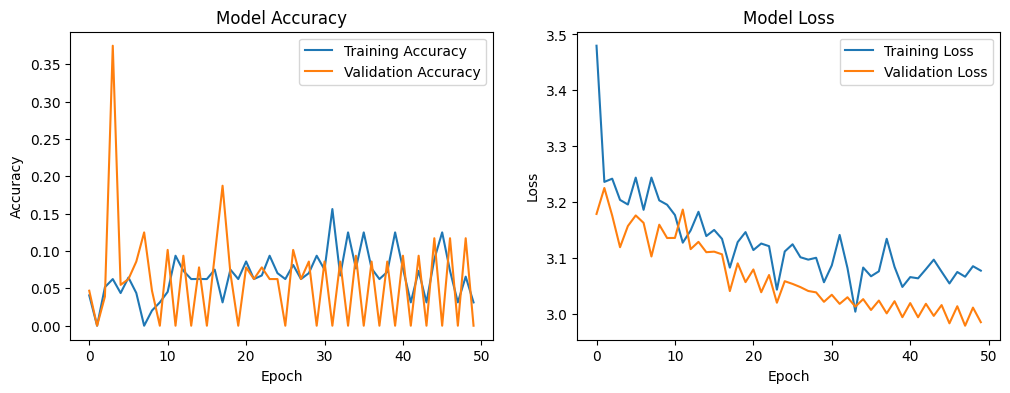


Evaluating ResNet50...
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ResNet50 Evaluation Results:
accuracy: 0.0833
precision: 0.0128
recall: 0.0833
f1: 0.0216

Training InceptionV3...
Epoch 1/50


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.0543 - loss: 3.5185 - val_accuracy: 0.2344 - val_loss: 2.8069 - learning_rate: 0.0010
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:22 4s/step - accuracy: 0.0625 - loss: 3.1362

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.0625 - loss: 3.1362 - val_accuracy: 0.1875 - val_loss: 2.7821 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.1603 - loss: 2.8886 - val_accuracy: 0.3906 - val_loss: 2.4903 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2812 - loss: 2.6989 - val_accuracy: 0.8750 - val_loss: 2.2495 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.2853 - loss: 2.4538 - val_accuracy: 0.4297 - val_loss: 2.0182 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.4839 - loss: 1.7782 - val_accuracy: 0.8750 - val_loss: 1.4067 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.4109 - loss: 2.0445 - val_accuracy: 0.4297 - val_loss: 1.7985 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.3125 - loss: 2.4964 - val_accuracy: 0.

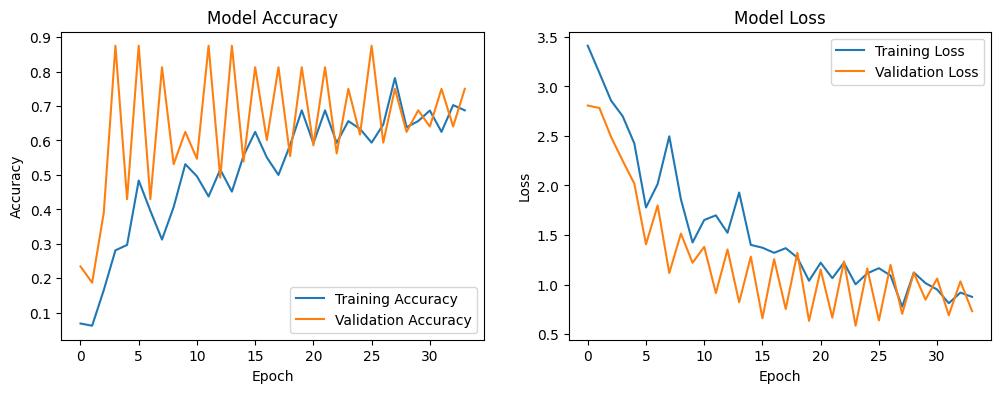


Evaluating InceptionV3...
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step
InceptionV3 Evaluation Results:
accuracy: 0.6181
precision: 0.6286
recall: 0.6181
f1: 0.5819

Training EfficientNetB0...


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.0403 - loss: 3.1944 - val_accuracy: 0.0469 - val_loss: 3.1907 - learning_rate: 0.0010
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.0000e+00 - loss: 3.2212

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.0000e+00 - loss: 3.2212 - val_accuracy: 0.0000e+00 - val_loss: 3.1390 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.0540 - loss: 3.1906 - val_accuracy: 0.0469 - val_loss: 3.1739 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.0312 - loss: 3.1878 - val_accuracy: 0.0000e+00 - val_loss: 3.2300 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.0409 - loss: 3.1907 - val_accuracy: 0.0469 - val_loss: 3.1848 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.1250 - loss: 3.1426 - val_accuracy: 0.0000e+00 - val_loss: 3.1486 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.0467 - loss: 3.1751 - val_accuracy: 0.0469 - val_loss: 3.1845 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.0000e+00 - loss: 3.2277 - v

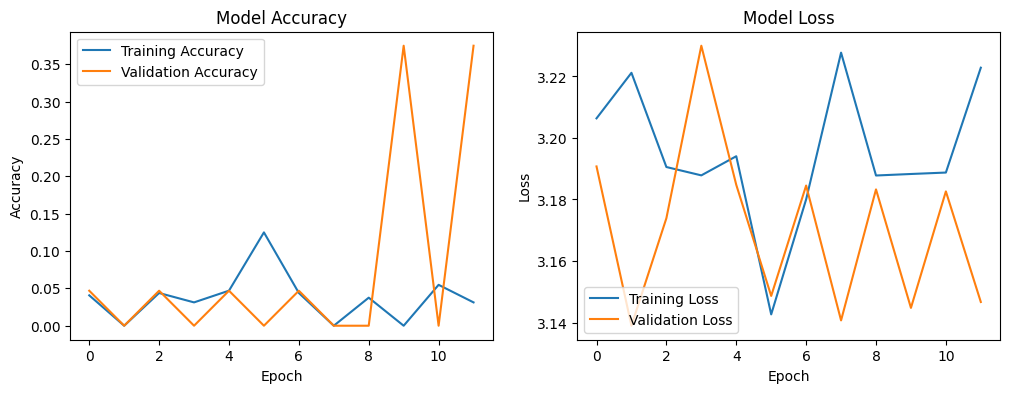


Evaluating EfficientNetB0...
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
EfficientNetB0 Evaluation Results:
accuracy: 0.0417
precision: 0.0017
recall: 0.0417
f1: 0.0033

Training CustomCNN...


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.0498 - loss: 3.7136 - val_accuracy: 0.0469 - val_loss: 3.1737 - learning_rate: 0.0010
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.0000e+00 - loss: 3.1794

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0000e+00 - loss: 3.1794 - val_accuracy: 0.0000e+00 - val_loss: 3.1731 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0417 - loss: 3.1764 - val_accuracy: 0.0469 - val_loss: 3.1745 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 3.1711 - val_accuracy: 0.0000e+00 - val_loss: 3.1729 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0295 - loss: 3.1739 - val_accuracy: 0.0469 - val_loss: 3.1228 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.0312 - loss: 3.1756 - val_accuracy: 0.0000e+00 - val_loss: 3.1215 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0575 - loss: 3.1474 - val_accuracy: 0.0469 - val_loss: 3.1187 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 3.1160

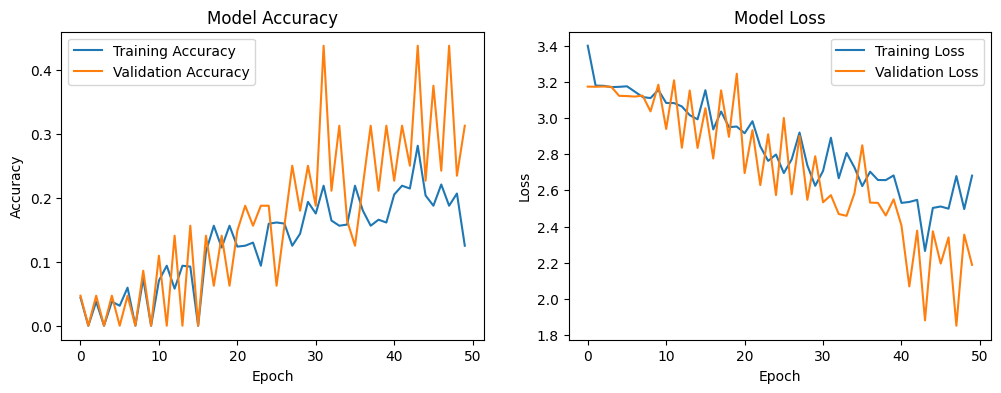


Evaluating CustomCNN...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step
CustomCNN Evaluation Results:
accuracy: 0.2292
precision: 0.1519
recall: 0.2292
f1: 0.1753
Evaluating MobileNetV2...


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Evaluating ResNet50...
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
Evaluating InceptionV3...


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step
Evaluating EfficientNetB0...


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Evaluating CustomCNN...


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MobileNetV2 Results:
accuracy: 0.6597
precision: 0.7061
recall: 0.6597
f1: 0.6437

ResNet50 Results:
accuracy: 0.0833
precision: 0.0128
recall: 0.0833
f1: 0.0216

InceptionV3 Results:
accuracy: 0.6181
precision: 0.6286
recall: 0.6181
f1: 0.5819

EfficientNetB0 Results:
accuracy: 0.0417
precision: 0.0017
recall: 0.0417
f1: 0.0033

CustomCNN Results:
accuracy: 0.2292
precision: 0.1519
recall: 0.2292
f1: 0.1753

Best model based on F1 score: MobileNetV2

Best model (MobileNetV2) saved to c:\Users\User\Nutismart-WebApp\RwandanFoodAI\models\best_model_MobileNetV2.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Predicted dish: Amaranth Greens (Dodo)
Actual dish: Amaranth Greens (Dodo)


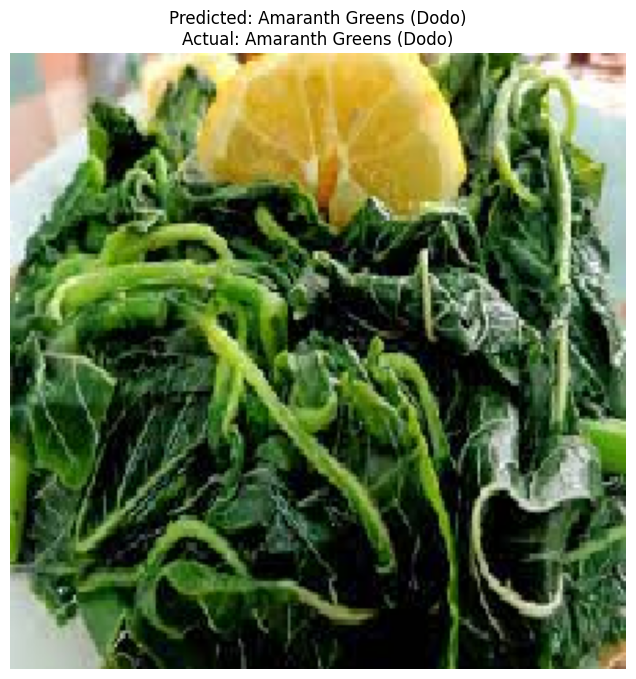


User Information:
Height: 170 cm
Weight: 70 kg
Health Goal: lose_weight
Favorite Dish: Cassava and Beans (Imyumbati n'ibishyimbo)
BMI: 24.22

Personalized Dish Recommendations:
- Cassava and Beans (Imyumbati n'ibishyimbo)
  Calories: 420
  Protein: 18g
  Carbs: 85g
  Total Fat: 2.0g
  Fiber: 18.0g
  Sodium: 30mg
  Dietary Info: Vegan
  Allergens: nan

- Sweet Potatoes with Beans (Ibijumba n'ibishyimbo)
  Calories: 455
  Protein: 27g
  Carbs: 98g
  Total Fat: 1.0g
  Fiber: 18.0g
  Sodium: 70mg
  Dietary Info: Vegan
  Allergens: nan

- Fresh Raw Veggies (Kachumbari)
  Calories: 80
  Protein: 2g
  Carbs: 14g
  Total Fat: 1.0g
  Fiber: 3.0g
  Sodium: 12mg
  Dietary Info: Vegan
  Allergens: nan

- Irish Potatoes and beans (Imvange)
  Calories: 320
  Protein: 18g
  Carbs: 60g
  Total Fat: 2.5g
  Fiber: 12.0g
  Sodium: 18mg
  Dietary Info: Vegan
  Allergens: nan

- Corn flour With Bean stew (Umutsima)
  Calories: 580
  Protein: 22g
  Carbs: 110g
  Total Fat: 12.0g
  Fiber: 20.0g
  Sodium: 32

In [72]:
# Main execution
# Main execution
if __name__ == "__main__":
    # Data preprocessing
    image_sizes = {
        'MobileNetV2': (224, 224),
        'ResNet50': (224, 224),
        'InceptionV3': (299, 299),
        'EfficientNetB0': (224, 224),
        'CustomCNN': (224, 224)
    }
    
    generators = {}
    class_weight_dicts = {}
    for model_name, size in image_sizes.items():
        print(f"Preprocessing data for {model_name} with image size {size}...")
        train_gen, val_gen, test_gen, class_weight_dict = preprocess_data(DATA_DIR, target_size=size)
        generators[model_name] = (train_gen, val_gen, test_gen)
        class_weight_dicts[model_name] = class_weight_dict
    
    print("\nData preprocessing completed.")
    print(f"Number of training samples: {generators['MobileNetV2'][0].samples}")
    print(f"Number of validation samples: {generators['MobileNetV2'][1].samples}")
    print(f"Number of test samples: {generators['MobileNetV2'][2].samples}")
    print(f"Number of classes: {len(generators['MobileNetV2'][0].class_indices)}")
    
    num_classes = len(generators['MobileNetV2'][0].class_indices)
    
    # Create models
    models = {
        'MobileNetV2': create_mobilenetv2_model(num_classes),
        'ResNet50': create_resnet50_model(num_classes),
        'InceptionV3': create_inceptionv3_model(num_classes, input_shape=(299, 299, 3)),
        'EfficientNetB0': create_efficientnetb0_model(num_classes),
        'CustomCNN': create_custom_cnn_model(num_classes)
    }
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        train_gen, val_gen, test_gen = generators[name]
        try:
            history = train_model(model, train_gen, val_gen, class_weight_dicts[name])
            plot_training_history(history)
            
            print(f"\nEvaluating {name}...")
            evaluation = evaluate_model(model, test_gen)
            print(f"{name} Evaluation Results:")
            for metric, value in evaluation.items():
                print(f"{metric}: {value:.4f}")
        except Exception as e:
            print(f"An error occurred while training/evaluating {name}: {str(e)}")
            print("Skipping to the next model.")
    
    # Compare models and select the best one
    try:
        best_model_name, results = compare_models(models, {name: gen[2] for name, gen in generators.items()})
        best_model = models[best_model_name]
        
        # Save the best model
        best_model_path = os.path.join(MODELS_DIR, f"best_model_{best_model_name}.h5")
        best_model.save(best_model_path)
        print(f"\nBest model ({best_model_name}) saved to {best_model_path}")
        
        # Example prediction using the best model
        test_gen = generators[best_model_name][2]
        test_images, test_labels = next(test_gen)
        predictions = best_model.predict(test_images)
        predicted_class = np.argmax(predictions[0])
        true_class = np.argmax(test_labels[0])
        
        class_names = list(generators[best_model_name][0].class_indices.keys())
        predicted_dish = class_names[predicted_class]
        true_dish = class_names[true_class]
        
        print(f"\nPredicted dish: {predicted_dish}")
        print(f"Actual dish: {true_dish}")
        
        # Display the sample image
        plt.figure(figsize=(8, 8))
        plt.imshow(test_images[0])
        plt.title(f"Predicted: {predicted_dish}\nActual: {true_dish}")
        plt.axis('off')
        plt.show()
        
        # Example user data for personalized recommendations
        user_height = 170  # cm
        user_weight = 70   # kg
        user_health_goal = 'lose_weight'  # 'lose_weight', 'gain_weight', or 'maintain'
        
        # Get user's favorite dish as an example of their preference
        user_favorite_dish = df.sample(n=1).iloc[0]
        
        print("\nUser Information:")
        print(f"Height: {user_height} cm")
        print(f"Weight: {user_weight} kg")
        print(f"Health Goal: {user_health_goal}")
        print(f"Favorite Dish: {user_favorite_dish['Name']}")
        
        # Calculate user's BMI
        user_bmi = calculate_bmi(user_height, user_weight)
        print(f"BMI: {user_bmi:.2f}")
        
        # Get personalized recommendations
        recommendations = recommend_dishes(user_favorite_dish, user_height, user_weight, user_health_goal, df)
        
        print("\nPersonalized Dish Recommendations:")
        for _, dish in recommendations.iterrows():
            print(f"- {dish['Name']}")
            print(f"  Calories: {dish['Calories']}")
            print(f"  Protein: {dish['Protein (g)']}g")
            print(f"  Carbs: {dish['Carbs (g)']}g")
            print(f"  Total Fat: {dish['Total Fat (g)']}g")
            print(f"  Fiber: {dish['Fiber (g)']}g")
            print(f"  Sodium: {dish['Sodium (mg)']}mg")
            print(f"  Dietary Info: {dish['Dietary Info']}")
            print(f"  Allergens: {dish['Allergens']}")
            print()

    except Exception as e:
        print(f"An error occurred during model comparison or recommendation: {str(e)}")

    print("Analysis and recommendations complete.")

<Figure size 1200x600 with 0 Axes>

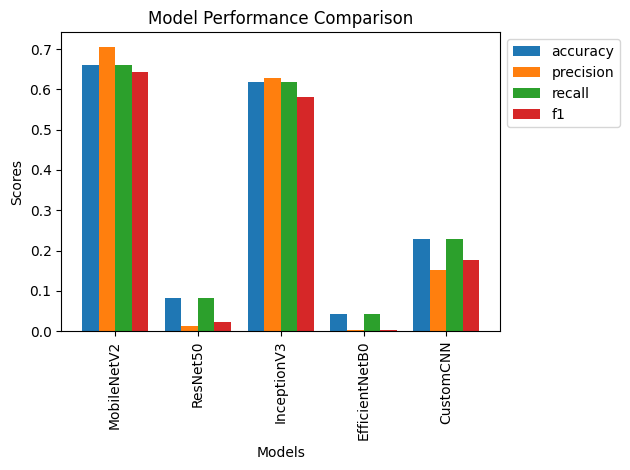

The best model based on F1 score is: MobileNetV2


Found 144 images belonging to 24 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


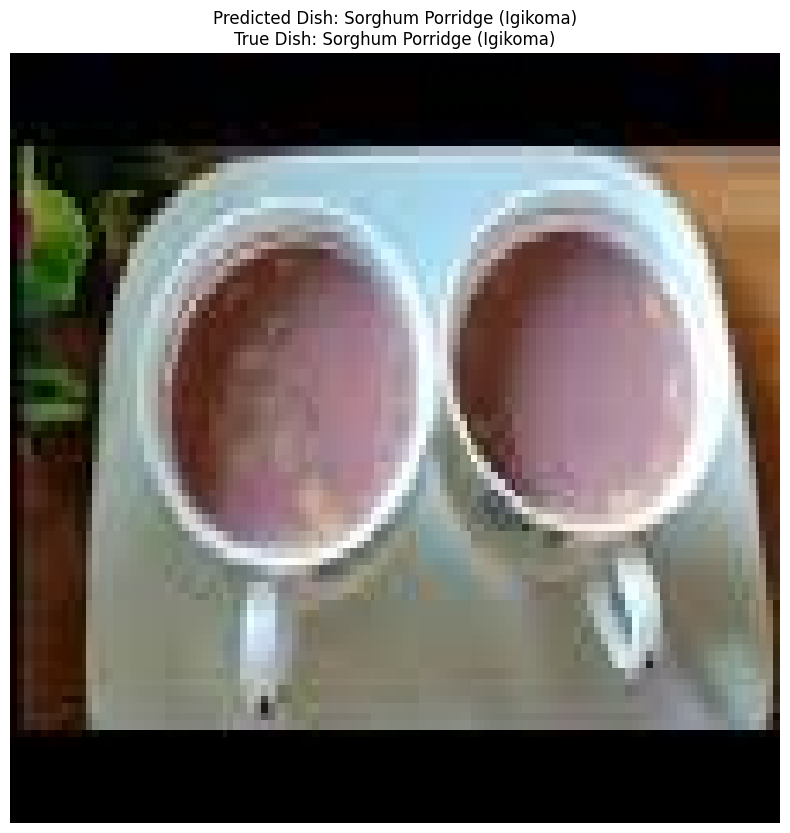


Nutritional Information:
Calories: 310
Protein: 10g
Carbs: 58g
Total Fat: 5.0g
Fiber: 6.0g

Similar Dishes:
- Rice and Bean Stew (Umuceri n'ibishyimbo)
- Corn flour With Bean stew (Umutsima)
- Fresh Raw Veggies (Kachumbari)

Personalized Recommendations:
- Sweet Potatoes with Beans (Ibijumba n'ibishyimbo)
  Calories: 455
  Protein: 27g
  Carbs: 98g
  Total Fat: 1.0g
  Fiber: 18.0g

- Bean Stew (Isosi y'Ibishyimbo)
  Calories: 330
  Protein: 22g
  Carbs: 58g
  Total Fat: 4.0g
  Fiber: 22.0g

- Grilled Tilapia (Ifi yokeje)
  Calories: 220
  Protein: 42g
  Carbs: 0g
  Total Fat: 5.0g
  Fiber: 0.0g

Analysis and recommendations complete.


In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity

# Model comparison results
model_results = {
    'MobileNetV2': {'accuracy': 0.6597, 'precision': 0.7061, 'recall': 0.6597, 'f1': 0.6437},
    'ResNet50': {'accuracy': 0.0833, 'precision': 0.0128, 'recall': 0.0833, 'f1': 0.0216},
    'InceptionV3': {'accuracy': 0.6181, 'precision': 0.6286, 'recall': 0.6181, 'f1': 0.5819},
    'EfficientNetB0': {'accuracy': 0.0417, 'precision': 0.0017, 'recall': 0.0417, 'f1': 0.0033},
    'CustomCNN': {'accuracy': 0.2292, 'precision': 0.1519, 'recall': 0.2292, 'f1': 0.1753}
}

# Convert results to a DataFrame for easier plotting
df_results = pd.DataFrame(model_results).T

# Create a bar plot to compare model performances
plt.figure(figsize=(12, 6))
df_results.plot(kind='bar', width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Identify the best model based on F1 score
best_model_name = max(model_results, key=lambda x: model_results[x]['f1'])
print(f"The best model based on F1 score is: {best_model_name}")

# Load the best model (assuming it's saved in the 'models' directory)
model_path = f"models/best_model_{best_model_name}.h5"
best_model = load_model(model_path)

# Function to get dish recommendations based on similarity
def get_similar_dishes(predicted_dish, df, num_recommendations=3):
    df['similarity'] = df[['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].apply(
        lambda row: cosine_similarity(
            [row], 
            [df.loc[df['Name'] == predicted_dish, ['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].iloc[0]]
        )[0][0],
        axis=1
    )
    return df.sort_values('similarity', ascending=False).iloc[1:num_recommendations+1]

# Load a random test image from the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'Dataset/Rwandandishies/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

# Get a random test image and its true label
test_image, test_label = next(test_generator)
true_class = np.argmax(test_label)

# Make a prediction
prediction = best_model.predict(test_image)
predicted_class = np.argmax(prediction[0])

# Get class names
class_names = list(test_generator.class_indices.keys())
predicted_dish = class_names[predicted_class]
true_dish = class_names[true_class]

# Display the results
plt.figure(figsize=(10, 10))
plt.imshow(test_image[0])
plt.title(f"Predicted Dish: {predicted_dish}\nTrue Dish: {true_dish}")
plt.axis('off')
plt.show()

# Load the nutrition data
df = pd.read_csv("data/nutrition/rwandan_food_data.csv")

# Print nutritional information
nutritional_info = df.loc[df['Name'] == predicted_dish].iloc[0]
print("\nNutritional Information:")
print(f"Calories: {nutritional_info['Calories']}")
print(f"Protein: {nutritional_info['Protein (g)']}g")
print(f"Carbs: {nutritional_info['Carbs (g)']}g")
print(f"Total Fat: {nutritional_info['Total Fat (g)']}g")
print(f"Fiber: {nutritional_info['Fiber (g)']}g")

# Get similar dishes
similar_dishes = get_similar_dishes(predicted_dish, df)
print("\nSimilar Dishes:")
for _, dish in similar_dishes.iterrows():
    print(f"- {dish['Name']}")

# Personalized recommendation (using the same user info as before)
user_height = 170  # cm
user_weight = 70   # kg
user_health_goal = 'lose_weight'

user_bmi = user_weight / (user_height / 100) ** 2

def get_dietary_recommendations(bmi, health_goal):
    if bmi < 18.5:
        return "high_calorie" if health_goal == 'gain_weight' else "balanced"
    elif 18.5 <= bmi < 25:
        return "balanced"
    elif 25 <= bmi < 30:
        return "low_calorie" if health_goal == 'lose_weight' else "balanced"
    else:
        return "low_calorie"

dietary_recommendation = get_dietary_recommendations(user_bmi, user_health_goal)

# Filter dishes based on dietary recommendation
if dietary_recommendation == "low_calorie":
    recommended_dishes = df[df['Calories'] < df['Calories'].median()]
elif dietary_recommendation == "high_calorie":
    recommended_dishes = df[df['Calories'] > df['Calories'].median()]
else:
    recommended_dishes = df

# Sort by nutritional balance (you can adjust this based on your specific criteria)
recommended_dishes['nutritional_score'] = recommended_dishes['Protein (g)'] + recommended_dishes['Fiber (g)'] - recommended_dishes['Total Fat (g)']
recommended_dishes = recommended_dishes.sort_values('nutritional_score', ascending=False).head(3)

print("\nPersonalized Recommendations:")
for _, dish in recommended_dishes.iterrows():
    print(f"- {dish['Name']}")
    print(f"  Calories: {dish['Calories']}")
    print(f"  Protein: {dish['Protein (g)']}g")
    print(f"  Carbs: {dish['Carbs (g)']}g")
    print(f"  Total Fat: {dish['Total Fat (g)']}g")
    print(f"  Fiber: {dish['Fiber (g)']}g")
    print()

print("Analysis and recommendations complete.")

Loaded model: models/best_model_MobileNetV2.h5
Found 144 images belonging to 24 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


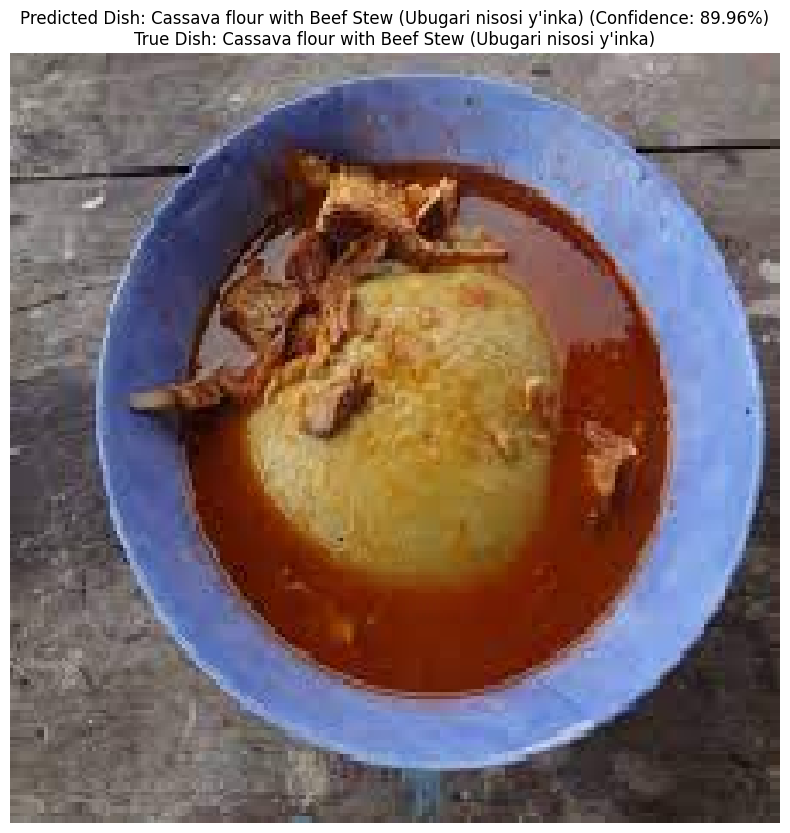


Prediction Results:
Predicted Dish: Cassava flour with Beef Stew (Ubugari nisosi y'inka)
Prediction Confidence: 89.96%
True Dish: Cassava flour with Beef Stew (Ubugari nisosi y'inka)
Correct Prediction: Yes

Nutritional Information:
Calories: 680
Protein: 32g
Carbs: 100g
Total Fat: 24.0g
Fiber: 8.0g

Similar Dishes:
- Green bananas with meat (Agatogo)
- Chicken with green bananas (Igisafuriya)
- Rice and Bean Stew (Umuceri n'ibishyimbo)

User Information:
Name: John Doe
Age: 30
Gender: Male
Height: 170 cm
Weight: 70 kg
BMI: 24.22
Activity Level: Moderately Active
Health Goal: lose_weight
Dietary Restrictions: lactose intolerant
Estimated Daily Calorie Needs: 2591 calories

Personalized Recommendations:
- Cassava flour with Beef Stew (Ubugari nisosi y'inka)
  Calories: 680
  Protein: 32g
  Carbs: 100g
  Total Fat: 24.0g
  Fiber: 8.0g
  Score: 0.09

- Rice and Bean Stew (Umuceri n'ibishyimbo)
  Calories: 720
  Protein: 28g
  Carbs: 130g
  Total Fat: 12.0g
  Fiber: 16.0g
  Score: 0.09

-

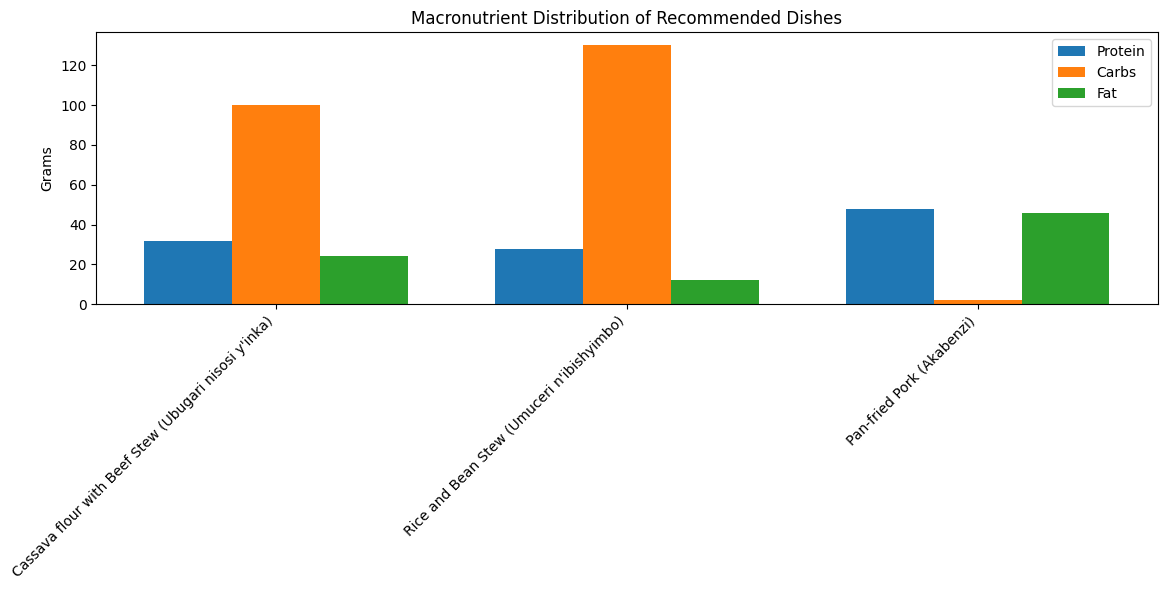

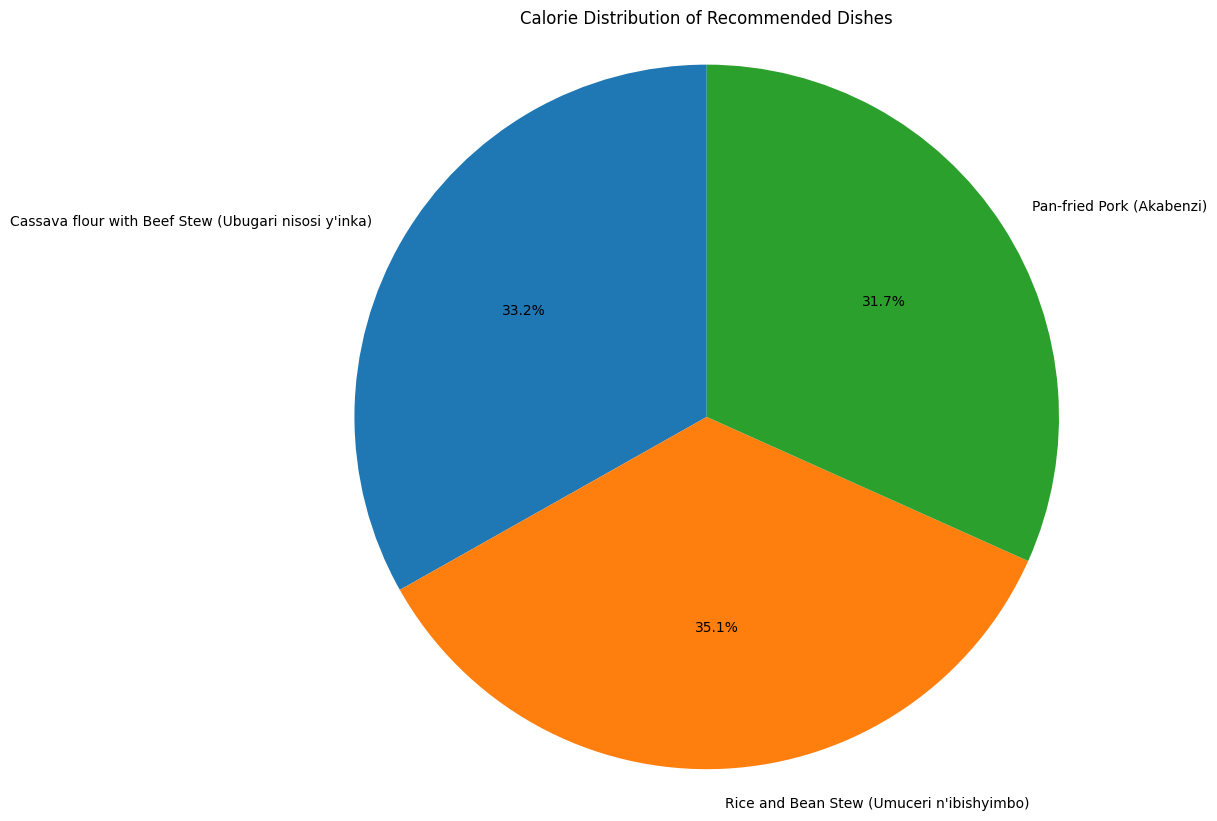

Analysis and recommendations complete.


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved MobileNetV2 model
model_path = "models/best_model_MobileNetV2.h5"
best_model = load_model(model_path)

print("Loaded model:", model_path)

# Load a random test image from the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'Dataset/Rwandandishies/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

# Get a random test image and its true label
test_image, test_label = next(test_generator)
true_class = np.argmax(test_label)

# Make a prediction
prediction = best_model.predict(test_image)
predicted_class = np.argmax(prediction[0])
prediction_accuracy = np.max(prediction[0])  # Get the confidence level of the prediction

# Get class names
class_names = list(test_generator.class_indices.keys())
predicted_dish = class_names[predicted_class]
true_dish = class_names[true_class]

# Display the results
plt.figure(figsize=(10, 10))
plt.imshow(test_image[0])
plt.title(f"Predicted Dish: {predicted_dish} (Confidence: {prediction_accuracy:.2%})\nTrue Dish: {true_dish}")
plt.axis('off')
plt.show()

# Print prediction results
print("\nPrediction Results:")
print(f"Predicted Dish: {predicted_dish}")
print(f"Prediction Confidence: {prediction_accuracy:.2%}")
print(f"True Dish: {true_dish}")
print(f"Correct Prediction: {'Yes' if predicted_dish == true_dish else 'No'}")

# Load the nutrition data
df = pd.read_csv("data/nutrition/rwandan_food_data.csv")

# Print nutritional information
nutritional_info = df.loc[df['Name'] == predicted_dish].iloc[0]
print("\nNutritional Information:")
print(f"Calories: {nutritional_info['Calories']}")
print(f"Protein: {nutritional_info['Protein (g)']}g")
print(f"Carbs: {nutritional_info['Carbs (g)']}g")
print(f"Total Fat: {nutritional_info['Total Fat (g)']}g")
print(f"Fiber: {nutritional_info['Fiber (g)']}g")

# Function to get dish recommendations based on similarity
def get_similar_dishes(predicted_dish, df, num_recommendations=3):
    df['similarity'] = df[['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].apply(
        lambda row: cosine_similarity(
            [row], 
            [df.loc[df['Name'] == predicted_dish, ['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].iloc[0]]
        )[0][0],
        axis=1
    )
    return df.sort_values('similarity', ascending=False).iloc[1:num_recommendations+1]

# Get similar dishes
similar_dishes = get_similar_dishes(predicted_dish, df)
print("\nSimilar Dishes:")
for _, dish in similar_dishes.iterrows():
    print(f"- {dish['Name']}")

# User information
class User:
    def __init__(self, name, age, gender, height, weight, activity_level, health_goal, dietary_restrictions):
        self.name = name
        self.age = age
        self.gender = gender
        self.height = height
        self.weight = weight
        self.activity_level = activity_level
        self.health_goal = health_goal
        self.dietary_restrictions = dietary_restrictions
        self.bmi = self.calculate_bmi()

    def calculate_bmi(self):
        return self.weight / (self.height / 100) ** 2

    def calculate_bmr(self):
        if self.gender.lower() == 'male':
            bmr = 88.362 + (13.397 * self.weight) + (4.799 * self.height) - (5.677 * self.age)
        else:
            bmr = 447.593 + (9.247 * self.weight) + (3.098 * self.height) - (4.330 * self.age)
        return bmr

    def calculate_tdee(self):
        activity_factors = {
            'sedentary': 1.2,
            'lightly active': 1.375,
            'moderately active': 1.55,
            'very active': 1.725,
            'extra active': 1.9
        }
        return self.calculate_bmr() * activity_factors[self.activity_level.lower()]

# Create a user
user = User(
    name="John Doe",
    age=30,
    gender="Male",
    height=170,  # cm
    weight=70,   # kg
    activity_level="Moderately Active",
    health_goal="lose_weight",
    dietary_restrictions=["lactose intolerant"]
)

print("\nUser Information:")
print(f"Name: {user.name}")
print(f"Age: {user.age}")
print(f"Gender: {user.gender}")
print(f"Height: {user.height} cm")
print(f"Weight: {user.weight} kg")
print(f"BMI: {user.bmi:.2f}")
print(f"Activity Level: {user.activity_level}")
print(f"Health Goal: {user.health_goal}")
print(f"Dietary Restrictions: {', '.join(user.dietary_restrictions)}")
print(f"Estimated Daily Calorie Needs: {user.calculate_tdee():.0f} calories")

def get_dietary_recommendations(user):
    if user.bmi < 18.5:
        return "high_calorie" if user.health_goal == 'gain_weight' else "balanced"
    elif 18.5 <= user.bmi < 25:
        return "balanced"
    elif 25 <= user.bmi < 30:
        return "low_calorie" if user.health_goal == 'lose_weight' else "balanced"
    else:
        return "low_calorie"

dietary_recommendation = get_dietary_recommendations(user)

# Filter dishes based on dietary recommendation and restrictions
if dietary_recommendation == "low_calorie":
    recommended_dishes = df[df['Calories'] < df['Calories'].median()]
elif dietary_recommendation == "high_calorie":
    recommended_dishes = df[df['Calories'] > df['Calories'].median()]
else:
    recommended_dishes = df

# Apply dietary restrictions
for restriction in user.dietary_restrictions:
    recommended_dishes = recommended_dishes[~recommended_dishes['Allergens'].str.contains(restriction, case=False, na=False)]

# Calculate target macronutrient ratios based on health goal
if user.health_goal == 'lose_weight':
    protein_ratio, carb_ratio, fat_ratio = 0.4, 0.3, 0.3
elif user.health_goal == 'gain_weight':
    protein_ratio, carb_ratio, fat_ratio = 0.3, 0.5, 0.2
else:
    protein_ratio, carb_ratio, fat_ratio = 0.3, 0.4, 0.3

# Calculate scores based on macronutrient ratios and user's TDEE
recommended_dishes['score'] = (
    (recommended_dishes['Protein (g)'] * 4 * protein_ratio +
     recommended_dishes['Carbs (g)'] * 4 * carb_ratio +
     recommended_dishes['Total Fat (g)'] * 9 * fat_ratio) / user.calculate_tdee()
)

# Sort by score and select top recommendations
recommended_dishes = recommended_dishes.sort_values('score', ascending=False).head(3)

print("\nPersonalized Recommendations:")
for _, dish in recommended_dishes.iterrows():
    print(f"- {dish['Name']}")
    print(f"  Calories: {dish['Calories']}")
    print(f"  Protein: {dish['Protein (g)']}g")
    print(f"  Carbs: {dish['Carbs (g)']}g")
    print(f"  Total Fat: {dish['Total Fat (g)']}g")
    print(f"  Fiber: {dish['Fiber (g)']}g")
    print(f"  Score: {dish['score']:.2f}")
    print()

# Visualization of macronutrient distribution for recommended dishes
fig, ax = plt.subplots(figsize=(12, 6))

dishes = recommended_dishes['Name']
proteins = recommended_dishes['Protein (g)']
carbs = recommended_dishes['Carbs (g)']
fats = recommended_dishes['Total Fat (g)']

x = np.arange(len(dishes))
width = 0.25

ax.bar(x - width, proteins, width, label='Protein')
ax.bar(x, carbs, width, label='Carbs')
ax.bar(x + width, fats, width, label='Fat')

ax.set_ylabel('Grams')
ax.set_title('Macronutrient Distribution of Recommended Dishes')
ax.set_xticks(x)
ax.set_xticklabels(dishes, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Pie chart of calorie distribution for recommended dishes
fig, ax = plt.subplots(figsize=(10, 10))

sizes = recommended_dishes['Calories']
labels = recommended_dishes['Name']

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Calorie Distribution of Recommended Dishes')

plt.show()

print("Analysis and recommendations complete.")

Found 144 images belonging to 24 classes.


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Overall Accuracy: 65.97%


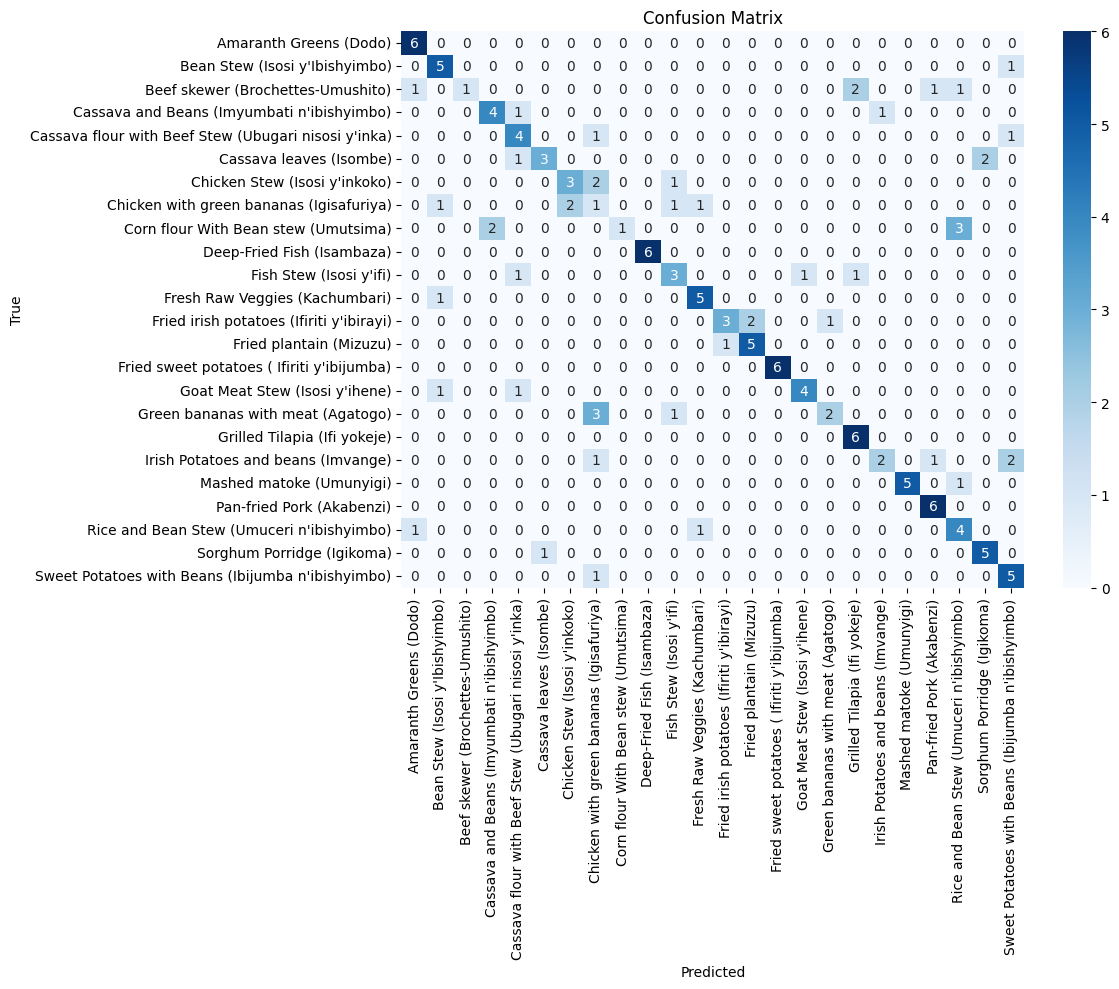

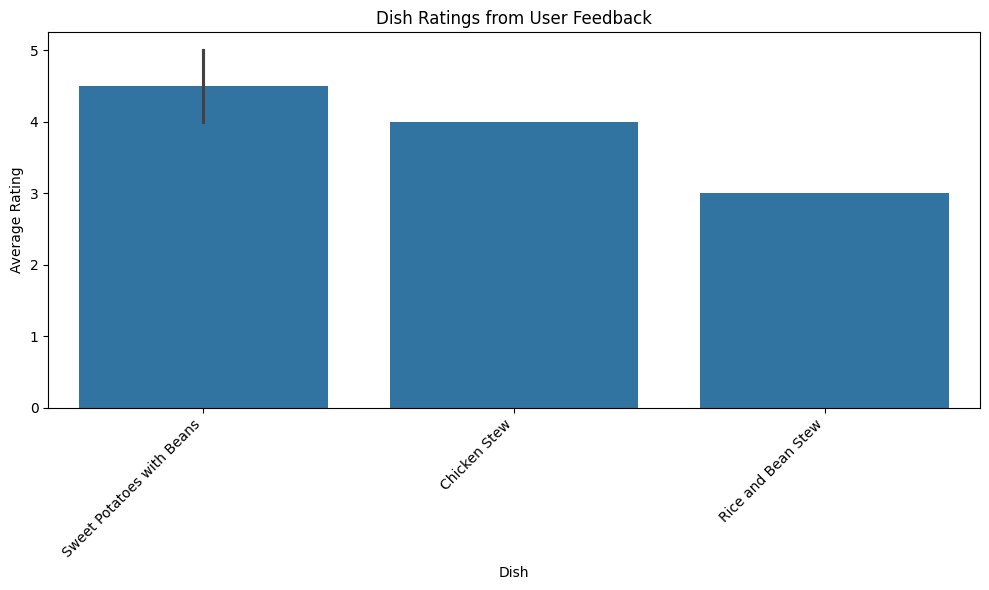

Top Rated Dishes:
Sweet Potatoes with Beans: 4.50
Chicken Stew: 4.00
Rice and Bean Stew: 3.00

Analysis complete.


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Diverse Test Cases
def evaluate_model_on_test_set(model, test_dir, batch_size=32):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Predict on the entire test set
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Calculate overall accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Overall Accuracy: {accuracy:.2%}")
    
    return y_true, y_pred, test_generator.class_indices

# 2. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# 3. User Feedback System
class FeedbackSystem:
    def __init__(self):
        self.feedback_data = []
    
    def collect_feedback(self, dish_name, rating, comment):
        self.feedback_data.append({
            'dish': dish_name,
            'rating': rating,
            'comment': comment
        })
    
    def display_feedback_summary(self):
        if not self.feedback_data:
            print("No feedback collected yet.")
            return
        
        dishes = [feedback['dish'] for feedback in self.feedback_data]
        ratings = [feedback['rating'] for feedback in self.feedback_data]
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=dishes, y=ratings)
        plt.title('Dish Ratings from User Feedback')
        plt.xlabel('Dish')
        plt.ylabel('Average Rating')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def get_top_rated_dishes(self, n=5):
        if not self.feedback_data:
            return []
        
        dish_ratings = {}
        for feedback in self.feedback_data:
            dish = feedback['dish']
            rating = feedback['rating']
            if dish in dish_ratings:
                dish_ratings[dish].append(rating)
            else:
                dish_ratings[dish] = [rating]
        
        avg_ratings = {dish: np.mean(ratings) for dish, ratings in dish_ratings.items()}
        top_dishes = sorted(avg_ratings.items(), key=lambda x: x[1], reverse=True)[:n]
        
        return top_dishes

# Usage example
if __name__ == "__main__":
    # Assuming 'best_model' is already loaded
    
    # 1. Evaluate on diverse test set
    test_dir = 'Dataset/Rwandandishies/test'  # Update this path as needed
    y_true, y_pred, class_indices = evaluate_model_on_test_set(best_model, test_dir)
    
    # 2. Plot confusion matrix
    class_names = list(class_indices.keys())
    plot_confusion_matrix(y_true, y_pred, class_names)
    
    # 3. Use feedback system
    feedback_system = FeedbackSystem()
    
    # Simulate some user feedback
    feedback_system.collect_feedback("Sweet Potatoes with Beans", 5, "Delicious!")
    feedback_system.collect_feedback("Chicken Stew", 4, "Very good")
    feedback_system.collect_feedback("Rice and Bean Stew", 3, "Average")
    feedback_system.collect_feedback("Sweet Potatoes with Beans", 4, "Enjoyable")
    
    # Display feedback summary
    feedback_system.display_feedback_summary()
    
    # Get top rated dishes
    top_dishes = feedback_system.get_top_rated_dishes()
    print("Top Rated Dishes:")
    for dish, rating in top_dishes:
        print(f"{dish}: {rating:.2f}")

    print("\nAnalysis complete.")

Loaded model from models/best_model_MobileNetV2.h5
Found 144 images belonging to 24 classes.


c:\Users\User\Nutismart-WebApp\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
Overall Accuracy: 65.97%

Classification Report:
                                                      precision    recall  f1-score   support

                              Amaranth Greens (Dodo)       0.75      1.00      0.86         6
                      Bean Stew (Isosi y'Ibishyimbo)       0.62      0.83      0.71         6
                   Beef skewer (Brochettes-Umushito)       1.00      0.17      0.29         6
          Cassava and Beans (Imyumbati n'ibishyimbo)       0.67      0.67      0.67         6
Cassava flour with Beef Stew (Ubugari nisosi y'inka)       0.50      0.67      0.57         6
                             Cassava leaves (Isombe)       0.75      0.50      0.60         6
                       Chicken Stew (Isosi y'inkoko)       0.60      0.50      0.55         6
            Chicken with green bananas (Igisafuriya)       0.11      0.17      0.13         6
                Corn flour With Bean stew (Umutsima)       1.00    

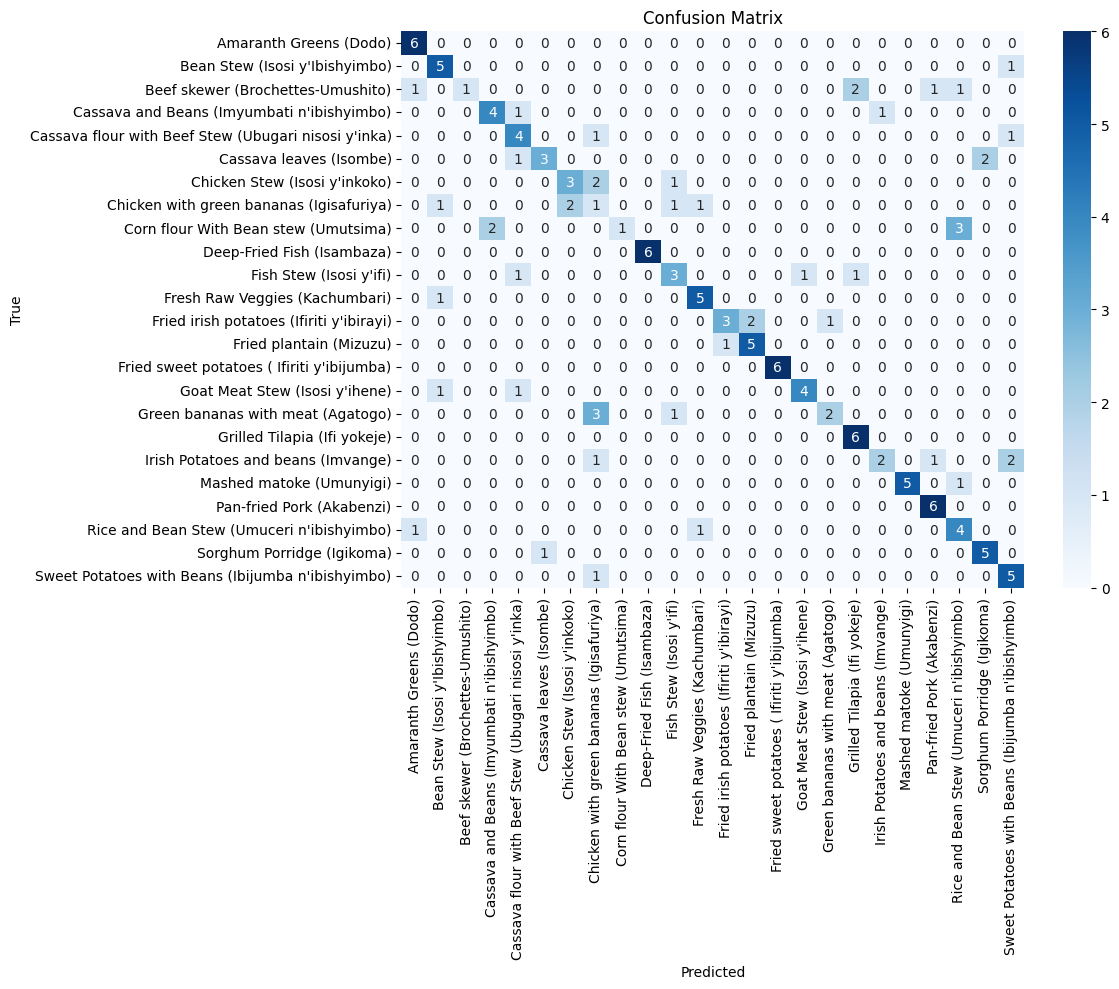

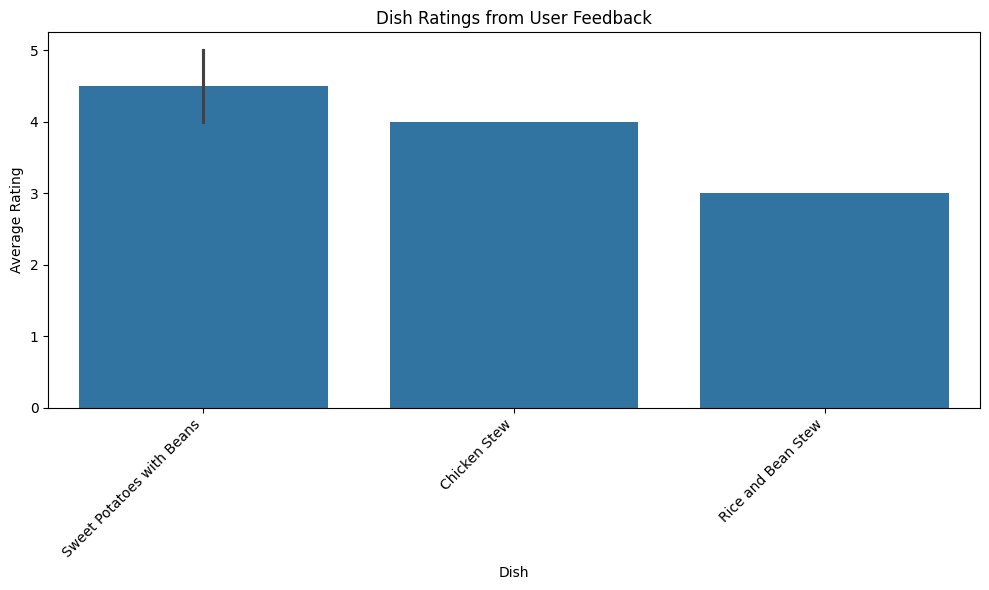

Top Rated Dishes:
Sweet Potatoes with Beans: 4.50
Chicken Stew: 4.00
Rice and Bean Stew: 3.00

Analysis complete.


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model_path = "models/best_model_MobileNetV2.h5"
best_model = load_model(model_path)
print(f"Loaded model from {model_path}")

# Function to evaluate the model on the test set
def evaluate_model_on_test_set(model, test_dir, batch_size=32):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Predict on the entire test set
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Calculate overall accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Overall Accuracy: {accuracy:.2%}")
    
    # Print classification report
    class_names = list(test_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    return y_true, y_pred, test_generator.class_indices

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# User Feedback System (same as before)
class FeedbackSystem:
    def __init__(self):
        self.feedback_data = []
    
    def collect_feedback(self, dish_name, rating, comment):
        self.feedback_data.append({
            'dish': dish_name,
            'rating': rating,
            'comment': comment
        })
    
    def display_feedback_summary(self):
        if not self.feedback_data:
            print("No feedback collected yet.")
            return
        
        dishes = [feedback['dish'] for feedback in self.feedback_data]
        ratings = [feedback['rating'] for feedback in self.feedback_data]
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=dishes, y=ratings)
        plt.title('Dish Ratings from User Feedback')
        plt.xlabel('Dish')
        plt.ylabel('Average Rating')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    def get_top_rated_dishes(self, n=5):
        if not self.feedback_data:
            return []
        
        dish_ratings = {}
        for feedback in self.feedback_data:
            dish = feedback['dish']
            rating = feedback['rating']
            if dish in dish_ratings:
                dish_ratings[dish].append(rating)
            else:
                dish_ratings[dish] = [rating]
        
        avg_ratings = {dish: np.mean(ratings) for dish, ratings in dish_ratings.items()}
        top_dishes = sorted(avg_ratings.items(), key=lambda x: x[1], reverse=True)[:n]
        
        return top_dishes

# Main execution
if __name__ == "__main__":
    # Evaluate on diverse test set
    test_dir = 'Dataset/Rwandandishies/test'  # Update this path as needed
    y_true, y_pred, class_indices = evaluate_model_on_test_set(best_model, test_dir)
    
    # Plot confusion matrix
    class_names = list(class_indices.keys())
    plot_confusion_matrix(y_true, y_pred, class_names)
    
    # Use feedback system
    feedback_system = FeedbackSystem()
    
    # Simulate some user feedback
    feedback_system.collect_feedback("Sweet Potatoes with Beans", 5, "Delicious!")
    feedback_system.collect_feedback("Chicken Stew", 4, "Very good")
    feedback_system.collect_feedback("Rice and Bean Stew", 3, "Average")
    feedback_system.collect_feedback("Sweet Potatoes with Beans", 4, "Enjoyable")
    
    # Display feedback summary
    feedback_system.display_feedback_summary()
    
    # Get top rated dishes
    top_dishes = feedback_system.get_top_rated_dishes()
    print("Top Rated Dishes:")
    for dish, rating in top_dishes:
        print(f"{dish}: {rating:.2f}")

    print("\nAnalysis complete.")

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved model
model_path = "models/best_model_MobileNetV2.h5"
best_model = load_model(model_path)
print(f"Loaded model from {model_path}")

# Load nutritional data
nutrition_data_path = "data/nutrition/rwandan_food_data.csv"
df = pd.read_csv(nutrition_data_path)

# Function to preprocess image
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Function to predict dish
def predict_dish(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = best_model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    return predicted_class, confidence

# Function to get dish recommendations based on similarity
def get_similar_dishes(predicted_dish, df, num_recommendations=3):
    df['similarity'] = df[['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].apply(
        lambda row: cosine_similarity(
            [row], 
            [df.loc[df['Name'] == predicted_dish, ['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].iloc[0]]
        )[0][0],
        axis=1
    )
    return df.sort_values('similarity', ascending=False).iloc[1:num_recommendations+1]

# User class
class User:
    def __init__(self, name, age, gender, height, weight, activity_level, health_goal, dietary_restrictions):
        self.name = name
        self.age = age
        self.gender = gender
        self.height = height
        self.weight = weight
        self.activity_level = activity_level
        self.health_goal = health_goal
        self.dietary_restrictions = dietary_restrictions
        self.bmi = self.calculate_bmi()

    def calculate_bmi(self):
        return self.weight / (self.height / 100) ** 2

    def calculate_bmr(self):
        if self.gender.lower() == 'male':
            bmr = 88.362 + (13.397 * self.weight) + (4.799 * self.height) - (5.677 * self.age)
        else:
            bmr = 447.593 + (9.247 * self.weight) + (3.098 * self.height) - (4.330 * self.age)
        return bmr

    def calculate_tdee(self):
        activity_factors = {
            'sedentary': 1.2,
            'lightly active': 1.375,
            'moderately active': 1.55,
            'very active': 1.725,
            'extra active': 1.9
        }
        return self.calculate_bmr() * activity_factors[self.activity_level.lower()]

# Function to get personalized recommendations
def get_personalized_recommendations(user, df, num_recommendations=3):
    if user.bmi < 18.5:
        calorie_filter = df['Calories'] > df['Calories'].median()
    elif user.bmi >= 25:
        calorie_filter = df['Calories'] < df['Calories'].median()
    else:
        calorie_filter = df['Calories'].between(df['Calories'].quantile(0.25), df['Calories'].quantile(0.75))
    
    recommended_dishes = df[calorie_filter]
    
    for restriction in user.dietary_restrictions:
        recommended_dishes = recommended_dishes[~recommended_dishes['Allergens'].str.contains(restriction, case=False, na=False)]
    
    recommended_dishes['score'] = (
        (recommended_dishes['Protein (g)'] * 4) +
        (recommended_dishes['Fiber (g)'] * 2) -
        (abs(recommended_dishes['Calories'] - user.calculate_tdee()) / 100)
    )
    
    return recommended_dishes.sort_values('score', ascending=False).head(num_recommendations)

# Main execution
if __name__ == "__main__":
    # Example usage with corrected image path
    image_path = r"C:\Users\User\Nutismart-WebApp\RwandanFoodAI\Dataset\Rwandandishies\test\Cassava leaves (Isombe)\Cassava leaves (Isombe) (30).jpg"
    predicted_class, confidence = predict_dish(image_path)
    
    # Get class names from the directory structure
    class_names = sorted(os.listdir(os.path.dirname(os.path.dirname(image_path))))
    predicted_dish = class_names[predicted_class]
    
    print(f"Predicted Dish: {predicted_dish}")
    print(f"Confidence: {confidence:.2%}")
    
    # Get nutritional information
    nutritional_info = df.loc[df['Name'] == predicted_dish].iloc[0]
    print("\nNutritional Information:")
    print(f"Calories: {nutritional_info['Calories']}")
    print(f"Protein: {nutritional_info['Protein (g)']}g")
    print(f"Carbs: {nutritional_info['Carbs (g)']}g")
    print(f"Total Fat: {nutritional_info['Total Fat (g)']}g")
    print(f"Fiber: {nutritional_info['Fiber (g)']}g")
    
    # Get similar dishes
    similar_dishes = get_similar_dishes(predicted_dish, df)
    print("\nSimilar Dishes:")
    for _, dish in similar_dishes.iterrows():
        print(f"- {dish['Name']}")
    
    # Create a user
    user = User(
        name="John Doe",
        age=30,
        gender="Male",
        height=170,  # cm
        weight=70,   # kg
        activity_level="Moderately Active",
        health_goal="lose_weight",
        dietary_restrictions=["lactose intolerant"]
    )
    
    # Get personalized recommendations
    recommendations = get_personalized_recommendations(user, df)
    print("\nPersonalized Recommendations:")
    for _, dish in recommendations.iterrows():
        print(f"- {dish['Name']}")
        print(f"  Calories: {dish['Calories']}")
        print(f"  Protein: {dish['Protein (g)']}g")
        print(f"  Carbs: {dish['Carbs (g)']}g")
        print(f"  Total Fat: {dish['Total Fat (g)']}g")
        print(f"  Fiber: {dish['Fiber (g)']}g")
        print(f"  Score: {dish['score']:.2f}")
        print()

    print("Analysis and recommendations complete.")

Loaded model from models/best_model_MobileNetV2.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Dish: Sorghum Porridge (Igikoma)
Confidence: 69.38%

Nutritional Information:
Calories: 310
Protein: 10g
Carbs: 58g
Total Fat: 5.0g
Fiber: 6.0g

Similar Dishes:
- Rice and Bean Stew (Umuceri n'ibishyimbo)
- Corn flour With Bean stew (Umutsima)
- Fresh Raw Veggies (Kachumbari)

Personalized Recommendations:
- Deep-Fried Fish (Isambaza)
  Calories: 380
  Protein: 40g
  Carbs: 1g
  Total Fat: 24.0g
  Fiber: 0.0g
  Score: 137.89

- Sweet Potatoes with Beans (Ibijumba n'ibishyimbo)
  Calories: 455
  Protein: 27g
  Carbs: 98g
  Total Fat: 1.0g
  Fiber: 18.0g
  Score: 122.64

- Bean Stew (Isosi y'Ibishyimbo)
  Calories: 330
  Protein: 22g
  Carbs: 58g
  Total Fat: 4.0g
  Fiber: 22.0g
  Score: 109.39

Analysis and recommendations complete.


Loaded model from models/best_model_MobileNetV2.h5
Selected random image: C:\Users\User\Nutismart-WebApp\RwandanFoodAI\Dataset\Rwandandishies\test\Fried sweet potatoes ( Ifiriti y'ibijumba)\Fried sweet potatoes ( Ifiriti y'ibijumba) (30).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Dish: Fried sweet potatoes ( Ifiriti y'ibijumba)
Confidence: 75.75%

Nutritional Information:
Calories: 420
Protein: 4g
Carbs: 62g
Total Fat: 22.0g
Fiber: 7.0g

Similar Dishes:
- Fried plantain (Mizuzu)
- Fried irish potatoes (Ifiriti y'ibirayi)
- Mashed matoke (Umunyigi)

Personalized Recommendations:
- Deep-Fried Fish (Isambaza)
  Calories: 380
  Protein: 40g
  Carbs: 1g
  Total Fat: 24.0g
  Fiber: 0.0g
  Score: 137.89

- Sweet Potatoes with Beans (Ibijumba n'ibishyimbo)
  Calories: 455
  Protein: 27g
  Carbs: 98g
  Total Fat: 1.0g
  Fiber: 18.0g
  Score: 122.64

- Bean Stew (Isosi y'Ibishyimbo)
  Calories: 330
  Protein: 22g
  Carbs: 58g
  Total Fat: 4.0g
  Fiber: 22.0g
  Score: 109.39



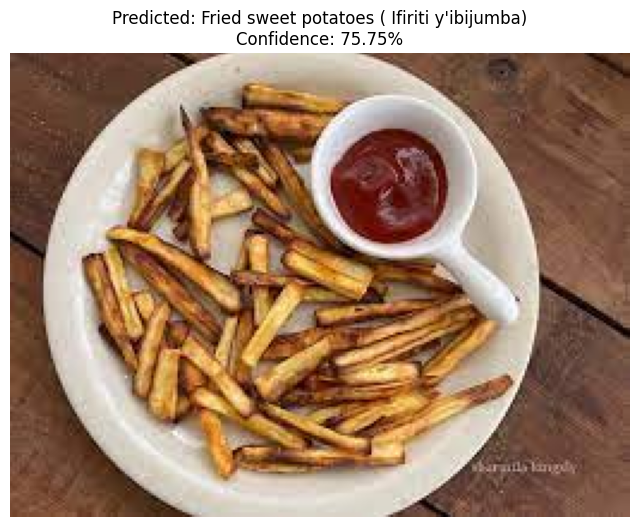

Analysis and recommendations complete.


In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved model
model_path = "models/best_model_MobileNetV2.h5"
best_model = load_model(model_path)
print(f"Loaded model from {model_path}")

# Load nutritional data
nutrition_data_path = "data/nutrition/rwandan_food_data.csv"
df = pd.read_csv(nutrition_data_path)

# Function to preprocess image
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Function to predict dish
def predict_dish(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = best_model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    return predicted_class, confidence

# Function to get dish recommendations based on similarity
def get_similar_dishes(predicted_dish, df, num_recommendations=3):
    df['similarity'] = df[['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].apply(
        lambda row: cosine_similarity(
            [row], 
            [df.loc[df['Name'] == predicted_dish, ['Protein (g)', 'Carbs (g)', 'Total Fat (g)', 'Fiber (g)']].iloc[0]]
        )[0][0],
        axis=1
    )
    return df.sort_values('similarity', ascending=False).iloc[1:num_recommendations+1]

# User class
class User:
    def __init__(self, name, age, gender, height, weight, activity_level, health_goal, dietary_restrictions):
        self.name = name
        self.age = age
        self.gender = gender
        self.height = height
        self.weight = weight
        self.activity_level = activity_level
        self.health_goal = health_goal
        self.dietary_restrictions = dietary_restrictions
        self.bmi = self.calculate_bmi()

    def calculate_bmi(self):
        return self.weight / (self.height / 100) ** 2

    def calculate_bmr(self):
        if self.gender.lower() == 'male':
            bmr = 88.362 + (13.397 * self.weight) + (4.799 * self.height) - (5.677 * self.age)
        else:
            bmr = 447.593 + (9.247 * self.weight) + (3.098 * self.height) - (4.330 * self.age)
        return bmr

    def calculate_tdee(self):
        activity_factors = {
            'sedentary': 1.2,
            'lightly active': 1.375,
            'moderately active': 1.55,
            'very active': 1.725,
            'extra active': 1.9
        }
        return self.calculate_bmr() * activity_factors[self.activity_level.lower()]

# Function to get personalized recommendations
def get_personalized_recommendations(user, df, num_recommendations=3):
    if user.bmi < 18.5:
        calorie_filter = df['Calories'] > df['Calories'].median()
    elif user.bmi >= 25:
        calorie_filter = df['Calories'] < df['Calories'].median()
    else:
        calorie_filter = df['Calories'].between(df['Calories'].quantile(0.25), df['Calories'].quantile(0.75))
    
    recommended_dishes = df[calorie_filter]
    
    for restriction in user.dietary_restrictions:
        recommended_dishes = recommended_dishes[~recommended_dishes['Allergens'].str.contains(restriction, case=False, na=False)]
    
    recommended_dishes['score'] = (
        (recommended_dishes['Protein (g)'] * 4) +
        (recommended_dishes['Fiber (g)'] * 2) -
        (abs(recommended_dishes['Calories'] - user.calculate_tdee()) / 100)
    )
    
    return recommended_dishes.sort_values('score', ascending=False).head(num_recommendations)

# Function to get a random image from the test folder
def get_random_image(test_dir):
    subfolders = [f.path for f in os.scandir(test_dir) if f.is_dir()]
    random_subfolder = random.choice(subfolders)
    images = [f for f in os.listdir(random_subfolder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random_image = random.choice(images)
    return os.path.join(random_subfolder, random_image)

# Main execution
if __name__ == "__main__":
    # Set the path to your test directory
    test_dir = r"C:\Users\User\Nutismart-WebApp\RwandanFoodAI\Dataset\Rwandandishies\test"
    
    # Get a random image
    image_path = get_random_image(test_dir)
    print(f"Selected random image: {image_path}")
    
    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
    else:
        predicted_class, confidence = predict_dish(image_path)
        
        # Get class names from the directory structure
        class_names = sorted(os.listdir(test_dir))
        predicted_dish = class_names[predicted_class]
        
        print(f"Predicted Dish: {predicted_dish}")
        print(f"Confidence: {confidence:.2%}")
        
        # Get nutritional information
        nutritional_info = df.loc[df['Name'] == predicted_dish].iloc[0]
        print("\nNutritional Information:")
        print(f"Calories: {nutritional_info['Calories']}")
        print(f"Protein: {nutritional_info['Protein (g)']}g")
        print(f"Carbs: {nutritional_info['Carbs (g)']}g")
        print(f"Total Fat: {nutritional_info['Total Fat (g)']}g")
        print(f"Fiber: {nutritional_info['Fiber (g)']}g")
        
        # Get similar dishes
        similar_dishes = get_similar_dishes(predicted_dish, df)
        print("\nSimilar Dishes:")
        for _, dish in similar_dishes.iterrows():
            print(f"- {dish['Name']}")
        
        # Create a user
        user = User(
            name="John Doe",
            age=30,
            gender="Male",
            height=170,  # cm
            weight=70,   # kg
            activity_level="Moderately Active",
            health_goal="lose_weight",
            dietary_restrictions=["lactose intolerant"]
        )
        
        # Get personalized recommendations
        recommendations = get_personalized_recommendations(user, df)
        print("\nPersonalized Recommendations:")
        for _, dish in recommendations.iterrows():
            print(f"- {dish['Name']}")
            print(f"  Calories: {dish['Calories']}")
            print(f"  Protein: {dish['Protein (g)']}g")
            print(f"  Carbs: {dish['Carbs (g)']}g")
            print(f"  Total Fat: {dish['Total Fat (g)']}g")
            print(f"  Fiber: {dish['Fiber (g)']}g")
            print(f"  Score: {dish['score']:.2f}")
            print()

        # Display the image
        plt.figure(figsize=(8, 8))
        img = load_img(image_path)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_dish}\nConfidence: {confidence:.2%}")
        plt.axis('off')
        plt.show()

        print("Analysis and recommendations complete.")